# **Transit Accessibility and Urban Safety**



Presentation Video Link:

https://drive.google.com/file/d/12QGnvjBewM2xOcVEt-kfGqwZrp18Df6I/view?usp=sharing

# Part 1: Introduction


## Problem Statement

We study whether and how public transit accessibility **SEPTA Trolley** and **Regional Rail** stations correlates with the **intensity and composition of reported crime** in Philadelphia. Using last year incident records with precise timestamps and coordinates, we quantify spatial and temporal patterns and build predictive models of crime counts around stations.

## Datasets

* **Philadelphia Police Crime Incidents (2024)** — event-level rows with date/time, UCR classification, district, latitude/longitude.
* **SEPTA Regional Rail Stations** — station points, line identifiers, coordinates.
* **SEPTA Trolley Stations** — station points, route identifiers, coordinates.


# Part 2: Data Loading & Preprocessing


For this step, we sought to import the relevant libraries required for all stages of our analysis pipeline data processing, exploratory data analysis, and model development.
These imports include essential Python data science packages such as pandas, numpy, and matplotlib for data handling and visualization, geopandas and folium for spatial analysis and interactive mapping, and scikit-learn / xgboost for building and validating predictive models.

In [ ]:
#Imports
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.spatial import cKDTree
import warnings
from shapely.ops import unary_union

warnings.filterwarnings('ignore')


## 2.1 Loading Philadelphia Crime Data (2024)

### 2.1.1 Loading Data & Converting to Dataframe



Given the large size of the Philadelphia crime dataset, we chose to store our files on Google Drive for easy and secure access from Colab.
To improve efficiency when handling over 100K records, we utilize the Pandas library for structured data processing and GeoPandas for spatial operations.
Both tools allow seamless reading of CSV and Shapefile formats, enabling fast and scalable data manipulation directly in the cloud environment.

In [ ]:
# Mount Google Drive to the specified path in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the file path (Sherry)
#crime_path = '/content/drive/MyDrive/545_project/crime_2024.csv'

# Set the file path (Chloe)
crime_path = '/content/drive/MyDrive/CIS 5450 - BDA/Final Project/crime_2024.csv'


In [ ]:
# Read the crime data from the specified path.
crimes = pd.read_csv(crime_path)

# Check the number of rows and columns in the DataFrame.
print(f"Rows: {crimes.shape[0]}, Columns: {crimes.shape[1]}")

# Display the first 5 rows of the DataFrame.
crimes.head(5)

Rows: 160388, Columns: 18


the_geom  cartodb_id  \
0  0101000020E610000014AB0862D9C852C0E0647B978CFE...       29148   
1  0101000020E6100000642EEFF856C652C020038BC69100...       29184   
2  0101000020E6100000185B883B62CE52C01022CD5003FB...       29197   
3                                                NaN       29219   
4  0101000020E6100000707272FEE7C952C0A8CC45FDE7FA...       29221   

                                the_geom_webmercator  objectid  dc_dist psa  \
0  0101000020110F000049A3EA6E50E85FC11DAA7FD4498E...  33616980       26   1   
1  0101000020110F00000FDFFB3B0DE45FC1ADE5A9318790...  33617009       24   1   
2  0101000020110F000045274B18B7F15FC13F1C10895E8A...  33617021       19   2   
3                                                NaN  33617043       22   3   
4  0101000020110F00007F24E0171CEA5FC1F976B541408A...  33617045        6   1   

       dispatch_date_time dispatch_date dispatch_time  hour        dc_key  \
0  2024-11-13 05:00:00+00    2024-11-13      00:00:00    19  2.024261e+11   
1  2024-07-26 04:00:00+00    2024-07-26      00:00:00     6  2.024241e+11   
2  2024-06-29 04:00:00+00    2024-06-29      00:00:00    20  2.024190e+11   
3  2024-06-22 04:00:00+00    2024-06-22      00:00:00     4  2.024220e+11   
4  2024-04-07 04:00:00+00    2024-04-07      00:00:00     9  2.024060e+11   

              location_block  ucr_general    text_general_code    point_x  \
0  300 BLOCK W CUMBERLAND ST          100  Homicide - Criminal -75.138268   
1   3800 BLOCK KENSINGTON AV          100  Homicide - Criminal -75.099058   
2          0 BLOCK N 52ND ST          100  Homicide - Criminal -75.224746   
3   1400 BLOCK WILLINGHAM ST          100  Homicide - Criminal        NaN   
4      900 BLOCK HAMILTON ST          100  Homicide - Criminal -75.154785   

     point_y        lat        lng  
0  39.988666  39.988666 -75.138268  
1  40.004449  40.004449 -75.099058  
2  39.961039  39.961039 -75.224746  
3        NaN        NaN        NaN  
4  39.960205  39.960205 -75.154785

### 2.1.2 Analyzing Data Structure

We generated summary statistics to ensure all geospatial coordinates and temporal attributes were within expected ranges before modeling.

In [ ]:
# display the datatypes and filled entries in `crime`
crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160388 entries, 0 to 160387
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   the_geom              153713 non-null  object 
 1   cartodb_id            160388 non-null  int64  
 2   the_geom_webmercator  153644 non-null  object 
 3   objectid              160388 non-null  int64  
 4   dc_dist               160388 non-null  int64  
 5   psa                   160337 non-null  object 
 6   dispatch_date_time    160388 non-null  object 
 7   dispatch_date         160388 non-null  object 
 8   dispatch_time         160388 non-null  object 
 9   hour                  160388 non-null  int64  
 10  dc_key                160388 non-null  float64
 11  location_block        160366 non-null  object 
 12  ucr_general           160388 non-null  int64  
 13  text_general_code     160388 non-null  object 
 14  point_x               153657 non-null  float64
 15  

In [ ]:
# display the descriptive statistics of `crime`
display(crimes.describe(include='all'))

the_geom    cartodb_id  \
count                                              153713  1.603880e+05   
unique                                              85872           NaN   
top     0101000020E6100000B10E2EBA48C452C015DB8B059101...           NaN   
freq                                                  430           NaN   
mean                                                  NaN  3.356732e+06   
std                                                   NaN  1.498614e+05   
min                                                   NaN  2.914800e+04   
25%                                                   NaN  3.313739e+06   
50%                                                   NaN  3.367130e+06   
75%                                                   NaN  3.407480e+06   
max                                                   NaN  3.468086e+06   

                                     the_geom_webmercator      objectid  \
count                                              153644  1.603880e+05   
unique                                              85871           NaN   
top     0101000020110F0000117C9F5A8FE05FC117D42E37A291...           NaN   
freq                                                  430           NaN   
mean                                                  NaN  1.848110e+07   
std                                                   NaN  3.446884e+06   
min                                                   NaN  1.213184e+07   
25%                                                   NaN  1.560351e+07   
50%                                                   NaN  1.846357e+07   
75%                                                   NaN  2.137003e+07   
max                                                   NaN  3.362322e+07   

              dc_dist     psa      dispatch_date_time dispatch_date  \
count   160388.000000  160337                  160388        160388   
unique            NaN       6                  131643           367   
top               NaN       2  2024-09-21 01:31:00+00    2024-07-29   
freq              NaN   50955                      10           585   
mean        17.404170     NaN                     NaN           NaN   
std         11.137643     NaN                     NaN           NaN   
min          1.000000     NaN                     NaN           NaN   
25%          9.000000     NaN                     NaN           NaN   
50%         16.000000     NaN                     NaN           NaN   
75%         24.000000     NaN                     NaN           NaN   
max         77.000000     NaN                     NaN           NaN   

       dispatch_time           hour        dc_key       location_block  \
count         160388  160388.000000  1.603880e+05               160366   
unique          1440            NaN           NaN                33253   
top         00:00:00            NaN           NaN  5500 BLOCK TULIP ST   
freq             345            NaN           NaN                  551   
mean             NaN      13.147299  2.036781e+11                  NaN   
std              NaN       5.674181  5.049247e+11                  NaN   
min              NaN       0.000000  1.992191e+11                  NaN   
25%              NaN       9.000000  2.024091e+11                  NaN   
50%              NaN      13.000000  2.024160e+11                  NaN   
75%              NaN      17.000000  2.024241e+11                  NaN   
max              NaN      23.000000  2.024170e+14                  NaN   

          ucr_general text_general_code        point_x        point_y  \
count   160388.000000            160388  153657.000000  153657.000000   
unique            NaN                31            NaN            NaN   
top               NaN            Thefts            NaN            NaN   
freq              NaN             40419            NaN            NaN   
mean       969.048183               NaN     -75.141408      39.991439   
std        623.709806               NaN       0.694351       0.3709

The descriptive summary of the Philadelphia crime dataset reveals several key patterns:

- Temporal Distribution

  The hour variable ranges from 0 to 23, with a mean of approximately 13 and a standard deviation of 5.7 hours, suggesting that reported crimes are relatively consistent throughout the day but tend to cluster around early afternoon to evening hours.

- Spatial Characteristics

  The latitude and longitude values range between 39.87°N to 42.22°N and –80.50°W to –74.95°W, which properly cover the Philadelphia metropolitan area.

  The low standard deviations (≈0.05 for latitude, 0.07 for longitude) confirm that most events are spatially concentrated within city limits.

- Crime Type & Frequency

  Among the text_general_code categories, Thefts appear most frequently, reflecting the dominance of property-related crimes in urban centers.

- District Variation

  The dc_dist variable spans from 1 to 77, highlighting coverage across all police districts.

In [ ]:
# Check unique police districts in the dataset
crimes['dc_dist'].unique()

array([26, 24, 19, 22,  6,  8,  3, 15, 12, 39, 18,  2, 25,  7, 14, 16, 35,
        1,  9, 17,  5, 77])

In [ ]:
# Check unique Police Service Areas (PSA)
crimes['psa'].unique()

array(['1', '2', '3', nan, '4', 'A', '5'], dtype=object)

In [ ]:
# Check unique crime types reported
crimes['text_general_code'].unique()

array(['Homicide - Criminal', 'Homicide - Justifiable',
       'Vandalism/Criminal Mischief', 'Thefts',
       'Aggravated Assault No Firearm', 'Burglary Residential',
       'All Other Offenses', 'Motor Vehicle Theft',
       'Receiving Stolen Property', 'Other Assaults',
       'Disorderly Conduct', 'Fraud', 'Theft from Vehicle',
       'Robbery No Firearm', 'Burglary Non-Residential',
       'Aggravated Assault Firearm', 'Robbery Firearm', 'Rape',
       'Narcotic / Drug Law Violations', 'Weapon Violations',
       'Other Sex Offenses (Not Commercialized)',
       'Offenses Against Family and Children',
       'DRIVING UNDER THE INFLUENCE', 'Arson', 'Embezzlement',
       'Forgery and Counterfeiting', 'Vagrancy/Loitering',
       'Prostitution and Commercialized Vice', 'Liquor Law Violations',
       'Gambling Violations', 'Public Drunkenness'], dtype=object)

### 2.1.3 Handling Redundant Data and Missing Values

Drop metadata and redundant columns, then rename the coordinate columns. We remove columns such as spatial geometry (the_geom), internal IDs (cartodb_id, objectid, dc_key), and projected coordinates (the_geom_webmercator, point_x, point_y) which are not needed for standard latitude/longitude analysis.

In [ ]:
columns_to_drop_crime = ['the_geom', 'cartodb_id', 'the_geom_webmercator', 'objectid', 'dc_key', 'point_x', 'point_y']

# Drop the identified columns from the DataFrame
crimes.drop(columns=columns_to_drop_crime, inplace=True, errors='ignore')

# Standardize Lat/Lng column names for consistency
crimes.rename(columns={'lat': 'latitude', 'lng': 'longitude'}, inplace=True)

Clean and validate geographic coordinates. Coordinates are first converted to numeric types, coercing non-numeric values to NaN. Then, records where coordinates are exactly 0.00000000 are treated as NaN and subsequently dropped to ensure reliable location data.

In [ ]:
# Convert coordinates to numeric, coercing errors to NaN
crimes['latitude'] = pd.to_numeric(crimes['latitude'], errors='coerce')
crimes['longitude'] = pd.to_numeric(crimes['longitude'], errors='coerce')

# Record initial rows for tracking data loss
initial_rows = len(crimes)
# Replace 0.00000000 (invalid placeholder) with NaN
crimes.replace(0.00000000, np.nan, inplace=True)
# Drop rows where latitude or longitude is NaN
crimes.dropna(subset=['latitude', 'longitude'], inplace=True)

# Output the number of rows removed due to invalid/missing coordinates
print(f"Removed {initial_rows - len(crimes)} rows with invalid/missing coordinates.")

Removed 6744 rows with invalid/missing coordinates.


Process the temporal column and filter the dataset. The 'dispatch_date_time' column is converted to a proper datetime object. A 'year' column is extracted to facilitate filtering, keeping only crime incidents recorded in the year 2024, consistent with the dataset's name and scope.


In [ ]:
# Convert the dispatch_date_time column to datetime objects
crimes['dispatch_date_time'] = pd.to_datetime(crimes['dispatch_date_time'], utc=True, errors='coerce')

# Extract the year for filtering purposes
crimes['year'] = crimes['dispatch_date_time'].dt.year

# Filter the data to keep only records from the year 2024
crime_ddf = crimes[crimes['year'] == 2024].copy()

# Print the final shape of the cleaned and filtered crime data
print(f"Filtered to 2024 data. Final Crime Data Shape: {crimes.shape}")

Filtered to 2024 data. Final Crime Data Shape: (153644, 12)


## 2.2 Loading Rail Stations Data

### 2.2.1 Loading Data & Converting to Dataframe


In [ ]:
# Set the file path (Sherry)
#rail_path = '/content/drive/MyDrive/545_project/Rail_Stations.csv'

# Set the file path (Chloe)
rail_path = '/content/drive/MyDrive/CIS 5450 - BDA/Final Project/Rail_Stations.csv'


In [ ]:
# Read the rail data from the specified path.
rail = pd.read_csv(rail_path)

# Check the number of rows and columns in the DataFrame.
print(f"Rows: {rail.shape[0]}, Columns: {rail.shape[1]}")

# Display the first 5 rows of the DataFrame.
rail.head(5)

Rows: 156, Columns: 8


X             Y  FID     Line_Name             Station_Na  \
0 -8.376410e+06  4.847938e+06    1  Airport Line     Airport Terminal A   
1 -8.376194e+06  4.847994e+06    2  Airport Line     Airport Terminal B   
2 -8.375850e+06  4.848131e+06    3  Airport Line  Airport Terminals C&D   
3 -8.375683e+06  4.848372e+06    4  Airport Line  Airport Terminals E&F   
4 -8.376233e+06  4.850210e+06    5  Airport Line               Eastwick   

    Latitude  Longitude                              GlobalID  
0  39.875992 -75.246574  9c8e904d-afd7-4660-9bac-a41c6119e38e  
1  39.876380 -75.244633  36026849-c648-4bc7-9efb-dc1c90bb98d8  
2  39.877322 -75.241542  b2f22e48-bb0a-402a-88db-76eefa51faa5  
3  39.878981 -75.240040  ee210d40-b5ed-4d3b-ac2f-5cfbb207ae66  
4  39.891651 -75.244981  5609f08b-d117-4374-b142-2abbd9bbd511

### 2.2.2 Analyzing Data Structure

We generated summary statistics to ensure all geospatial coordinates and temporal attributes were within expected ranges before modeling.

In [ ]:
# display the datatypes and filled entries in `rail`
rail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X           156 non-null    float64
 1   Y           156 non-null    float64
 2   FID         156 non-null    int64  
 3   Line_Name   156 non-null    object 
 4   Station_Na  156 non-null    object 
 5   Latitude    156 non-null    float64
 6   Longitude   156 non-null    float64
 7   GlobalID    156 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 9.9+ KB


In [ ]:
# display the descriptive statistics of `rail`
display(rail.describe(include='all'))

X             Y         FID             Line_Name  \
count   1.560000e+02  1.560000e+02  156.000000                   156   
unique           NaN           NaN         NaN                    14   
top              NaN           NaN         NaN  Paoli Thorndale Line   
freq             NaN           NaN         NaN                    22   
mean   -8.374150e+06  4.871194e+06   78.500000                   NaN   
std     1.881942e+04  1.716193e+04   45.177428                   NaN   
min    -8.433866e+06  4.818129e+06    1.000000                   NaN   
25%    -8.382778e+06  4.859210e+06   39.750000                   NaN   
50%    -8.373971e+06  4.871994e+06   78.500000                   NaN   
75%    -8.365911e+06  4.881702e+06  117.250000                   NaN   
max    -8.321576e+06  4.910539e+06  156.000000                   NaN   

                Station_Na    Latitude   Longitude  \
count                  156  156.000000  156.000000   
unique                 155         NaN         NaN   
top     North Philadelphia         NaN         NaN   
freq                     2         NaN         NaN   
mean                   NaN   40.036025  -75.226267   
std                    NaN    0.118049    0.169058   
min                    NaN   39.670183  -75.762704   
25%                    NaN   39.953653  -75.303777   
50%                    NaN   40.041633  -75.224664   
75%                    NaN   40.108364  -75.152256   
max                    NaN   40.306200  -74.753990   

                                    GlobalID  
count                                    156  
unique                                   156  
top     9c8e904d-afd7-4660-9bac-a41c6119e38e  
freq                                       1  
mean                                     NaN  
std                                      NaN  
min                                      NaN  
25%                                      NaN  
50%                                      NaN  
75%                                      NaN  
max                                      NaN

### 2.2.3 Handling Redundant Data and Missing Values

This section focuses on cleaning and preparing the Rail Station Data for subsequent analysis and merging. The key steps include standardizing column names for consistency across all datasets, ensuring the geographical coordinates are in the correct numeric format, removing any records with invalid or missing coordinates, and assigning a transport_type identifier.

In [ ]:
# 1. Select and rename columns for consistency
rail.rename(columns={'Longitude': 'longitude', 'Latitude': 'latitude', 'Station_Na': 'station_name', 'Line_Name': 'line'}, inplace=True)
rail = rail[['longitude', 'latitude', 'station_name', 'line']].copy()

# 2. Clean coordinate data
rail['latitude'] = pd.to_numeric(rail['latitude'], errors='coerce')
rail['longitude'] = pd.to_numeric(rail['longitude'], errors='coerce')
rail.dropna(subset=['latitude', 'longitude'], inplace=True)
rail['transport_type'] = 'Rail'
print(f"Rail Data Final Shape: {rail.shape}")

Rail Data Final Shape: (156, 5)


## 2.3 Loading Trolley Stations Data

### 2.3.1 Loading Data & Converting to Dataframe

In [ ]:
# Set the file path (Sherry)
#trolley_path = '/content/drive/MyDrive/545_project/Trolly_Stop.csv'

# Set the file path (Chloe)
trolley_path = '/content/drive/MyDrive/CIS 5450 - BDA/Final Project/Trolly_Stop.csv'


In [ ]:
# Read the trolley data from the specified path.
trolley = pd.read_csv(trolley_path)

# Check the number of rows and columns in the DataFrame.
print(f"Rows: {trolley.shape[0]}, Columns: {trolley.shape[1]}")

# Display the first 5 rows of the DataFrame.
trolley.head(5)

Rows: 655, Columns: 18


X             Y  FID   GISDBID     Mode  Route  Direction  \
0 -8.368617e+06  4.859267e+06    1  3620661W  Trolley     36  Westbound   
1 -8.369352e+06  4.859390e+06    2  3620662W  Trolley     36  Westbound   
2 -8.370638e+06  4.859244e+06    3  3620733W  Trolley     36  Westbound   
3 -8.370925e+06  4.858831e+06    4  3620734W  Trolley     36  Westbound   
4 -8.371994e+06  4.858242e+06    5  3620736W  Trolley     36  Westbound   

   Stop_Code                       Stop        Lat        Lon    Sign_Up  \
0      20661                    22nd St  39.954051 -75.176567  Fall 2024   
1      20662  Drexel Station at 30th St  39.954895 -75.183166  Fall 2024   
2      20733                    36th St  39.953887 -75.194717  Fall 2024   
3      20734                    37th St  39.951049 -75.197303  Fall 2024   
4      20736      Woodland Av & 42nd St  39.946987 -75.206901  Fall 2024   

   Weekday_On  Weekday_Of  Saturday_O  Saturday_1  Sunday_Ons  Sunday_Off  
0         293         103         149          61         115          40  
1         405         128         227          72         157          56  
2         133         148          59          61          33          44  
3         140         218          48          53          25          48  
4          10          31           5          19           5          12

### 2.3.2 Analyzing Data Structure

We generated summary statistics to ensure all geospatial coordinates and temporal attributes were within expected ranges before modeling.

In [ ]:
# display the datatypes and filled entries in 'trolley'
trolley.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X           655 non-null    float64
 1   Y           655 non-null    float64
 2   FID         655 non-null    int64  
 3   GISDBID     655 non-null    object 
 4   Mode        655 non-null    object 
 5   Route       655 non-null    int64  
 6   Direction   655 non-null    object 
 7   Stop_Code   655 non-null    int64  
 8   Stop        655 non-null    object 
 9   Lat         655 non-null    float64
 10  Lon         655 non-null    float64
 11  Sign_Up     655 non-null    object 
 12  Weekday_On  655 non-null    int64  
 13  Weekday_Of  655 non-null    int64  
 14  Saturday_O  655 non-null    int64  
 15  Saturday_1  655 non-null    int64  
 16  Sunday_Ons  655 non-null    int64  
 17  Sunday_Off  655 non-null    int64  
dtypes: float64(4), int64(9), object(5)
memory usage: 92.2+ KB


In [ ]:
# display the descriptive statistics of 'trolley'
display(trolley.describe(include='all'))

X             Y         FID   GISDBID     Mode       Route  \
count   6.550000e+02  6.550000e+02  655.000000       655      655  655.000000   
unique           NaN           NaN         NaN       655        1         NaN   
top              NaN           NaN         NaN  3620660W  Trolley         NaN   
freq             NaN           NaN         NaN         1      655         NaN   
mean   -8.374143e+06  4.858321e+06  328.000000       NaN      NaN   34.274809   
std     6.144770e+03  2.890688e+03  189.226496       NaN      NaN   33.727196   
min    -8.392821e+06  4.852390e+06    1.000000       NaN      NaN   10.000000   
25%    -8.376505e+06  4.855638e+06  164.500000       NaN      NaN   11.000000   
50%    -8.373926e+06  4.858514e+06  328.000000       NaN      NaN   15.000000   
75%    -8.370846e+06  4.860945e+06  491.500000       NaN      NaN   36.000000   
max    -8.360043e+06  4.863654e+06  655.000000       NaN      NaN  102.000000   

        Direction     Stop_Code     Stop         Lat         Lon    Sign_Up  \
count         655    655.000000      655  655.000000  655.000000        655   
unique          2           NaN      315         NaN         NaN          1   
top     Westbound           NaN  22nd St         NaN         NaN  Fall 2024   
freq          331           NaN       10         NaN         NaN        655   
mean          NaN  18401.749618      NaN   39.947528  -75.226211        NaN   
std           NaN   7204.596016      NaN    0.019908    0.055199        NaN   
min           NaN    277.000000      NaN   39.906673  -75.393997        NaN   
25%           NaN  18631.500000      NaN   39.929057  -75.247428        NaN   
50%           NaN  20734.000000      NaN   39.948863  -75.224258        NaN   
75%           NaN  20936.500000      NaN   39.965604  -75.196586        NaN   
max           NaN  32523.000000      NaN   39.984252  -75.099548        NaN   

         Weekday_On   Weekday_Of  Saturday_O  Saturday_1  Sunday_Ons  \
count    655.000000   655.000000  655.000000  655.000000  655.000000   
unique          NaN          NaN         NaN         NaN         NaN   
top             NaN          NaN         NaN         NaN         NaN   
freq            NaN          NaN         NaN         NaN         NaN   
mean      93.622901    91.800000   50.633588   48.647328   37.468702   
std      144.554826   141.977325   82.648717   78.843703   60.207987   
min        0.000000     0.000000    0.000000    0.000000    0.000000   
25%       16.000000    15.000000    8.000000    7.000000    6.000000   
50%       49.000000    48.000000   24.000000   23.000000   18.000000   
75%      115.500000   120.000000   60.000000   60.500000   44.000000   
max     1405.000000  1314.000000  846.000000  654.000000  600.000000   

        Sunday_Off  
count   655.000000  
unique         NaN  
top            NaN  
freq           NaN  
mean     36.163359  
std      58.206444  
min       0.000000  
25%       5.000000  
50%      17.000000  
75%      46.000000  
max     491.000000

### 2.3.3 Handling Redundant Data and Missing Values

This section focuses on preparing the Trolley_Stations.csv dataset for subsequent spatial analysis. The key steps include standardizing column names, specifically mapping Lon to longitude, Lat to latitude, StopName to station_name, and LineAbbr to line. Furthermore, the code cleans the geographical coordinates by converting them to a numeric format and dropping any rows where coordinate data is invalid or missing, ensuring data quality for accurate geospatial operations.

In [ ]:
# 1. Select and rename columns for consistency: Lon->longitude, Lat->latitude, Stop->station_name, Route->line
trolley.rename(columns={'Lon': 'longitude', 'Lat': 'latitude', 'Stop': 'station_name', 'Route': 'line'}, inplace=True)

# Select only the required columns and the 'Mode' field (for transport type)
columns_to_keep_trolley = ['longitude', 'latitude', 'station_name', 'line', 'Mode']
trolley = trolley[columns_to_keep_trolley].copy()

# 2. Clean coordinate data
trolley['latitude'] = pd.to_numeric(trolley['latitude'], errors='coerce')
trolley['longitude'] = pd.to_numeric(trolley['longitude'], errors='coerce')
trolley.dropna(subset=['latitude', 'longitude'], inplace=True)

# 3. Assign transport type: Rename 'Mode' to 'transport_type'
trolley.rename(columns={'Mode': 'transport_type'}, inplace=True)
trolley['transport_type'] = trolley['transport_type'].str.strip()
print(f"Trolley Data Final Shape: {trolley.shape}")

Trolley Data Final Shape: (655, 5)


## 2.4 Joining Dataframas

### 2.4.1 Combining Rail and Trolley Stations

Finally, we decide to join our dataframes to produce a holistic view of the data. To do this, we first combine `rail` and `trolley` datasets into a single comprehensive stations dataframe, called `stations`, and assign each station with a unique id, `station_id`.

In [ ]:
# Combine the rail stations and trolley stops into a single stations data frame
stations = pd.concat([rail, trolley], ignore_index=True)

# Assign each station with a unique id
stations['station_id'] = range(1, len(stations) + 1)

### 2.4.2 Assigning Crimes to Nearest Stations

After creating a comprehensive `stations` with both rail and trolley stations, the next step is to associate each crime incident with its nearest station. This assignment is based on a distance criterion: each crime is matched to the closest station, provided that the station is within 1,500 meters of the incident.


To achieve this, we perform several processing steps:
1. Create GeoDataFrames of stations and crimes for further spatial operations
2. Transform CRS data into UTM for accurate distance measurement
3. Assign each crime incident with the nearest station within 1500 meters


Through this process, the `crimes` dataframe is augmented with 2 new columns:
*  `assigned_station`: indicate the nearest station ID
*   `distance_to_station`: indicate the distance (in meters) between the crime and the assigned station





In [ ]:
# 1. Create GeoDataFrames for stations and crimes
# We convert the stations and crimes dataframes into GeoDataFrames, specifying the geometry using longitude (lng) and latitude (lat).
# This allows us to perform further spatial operations.

stations_gdf = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations['longitude'], stations['latitude']),
    crs="EPSG:4326" # Coordinates are in latitude and longitude (degrees)
)

crimes_gdf = gpd.GeoDataFrame(
    crimes,
    geometry=gpd.points_from_xy(crimes['longitude'], crimes['latitude']),
    crs="EPSG:4326" # Coordinates are in longitude and latitude (degrees).
)

In [ ]:
# 2. Transform CRS data into UTM for accurate distance measurement
# To calculate the actual distances between crime incidents and stations,
# we need to convert latitude/longitude coordinates into a UTM projection, which allows distances to be measured accurately in meters

# Compute the center of the data to determine the appropriate UTM zone
mean_lon = pd.concat([stations_gdf.geometry.x, crimes_gdf.geometry.x]).mean() # Center longitude of the data
mean_lat = pd.concat([stations_gdf.geometry.y, crimes_gdf.geometry.y]).mean() # Center latitude of the data

# Determine the corresponding UTM zone based on the data center
utm_zone = int((mean_lon + 180) / 6) + 1
epsg_code = 32600 + utm_zone if mean_lat >= 0 else 32700 + utm_zone
crs_proj = f"EPSG:{epsg_code}"

# Convert CRS of the data to UTM with units in meters
stations = stations_gdf.to_crs(crs_proj)
crimes = crimes_gdf.to_crs(crs_proj)

In [ ]:
# 3. Assign each crime incident with the nearest station within 1500 meters

# Extract coordinates
crime_coords = np.array([[pt.x, pt.y] for pt in crimes.geometry])
station_coords = np.array([[pt.x, pt.y] for pt in stations.geometry])

# Build KDTree to find the nearest station within 1500 meters for each crime incident
tree = cKDTree(station_coords)
max_distance_m = 1500  # Distance threshold

# distances: distance from each crime point to its nearest station
# indices: index of the nearest station in station_coords
distances, indices = tree.query(crime_coords, k=1, distance_upper_bound=max_distance_m)

# Assign results
crimes['assigned_station_id'] = None
crimes['distance_to_station'] = None

within_threshold = distances < np.inf
assigned_indices = crimes.index[within_threshold]

crimes.loc[assigned_indices, 'assigned_station_id'] = stations.iloc[indices[within_threshold]]['station_id'].values
crimes.loc[assigned_indices, 'distance_to_station'] = distances[within_threshold]

After identifying the corresponding station for each crime incident, we calculate the total number of crime incidents associated with each station and store this value in a new column `crime_counts` in `stations` dataframe.

In [ ]:
# Count crimes per station
crime_counts = crimes[crimes['assigned_station_id'].notna()]['assigned_station_id'].value_counts().reset_index()
crime_counts.columns = ['station_id', 'crime_count']

stations = stations.merge(crime_counts, on='station_id', how='left')
stations['crime_count'] = stations['crime_count'].fillna(0).astype(int)

The following summarizes the assignments of crime incidents to stations:

In [ ]:
# Summary
print(f"\n=== Results ===")
print()
print(f"Distance threshold: {max_distance_m}m")
print(f"Crimes assigned: {crimes['assigned_station_id'].notna().sum()} / {len(crimes)} ({crimes['assigned_station_id'].notna().sum()/len(crimes)*100:.1f}%)")
print(f"Mean distance: {crimes['distance_to_station'].mean():.1f}m")
print(f"\nTop 5 stations by crime count:")
print(stations[['station_id', 'crime_count']].sort_values('crime_count', ascending=False).head())

# Number of stations with crimes assigned
stations_with_crimes = (stations['crime_count'] > 0).sum()
total_stations = len(stations)

print()
print(f"Stations with crimes: {stations_with_crimes} / {total_stations} ({stations_with_crimes/total_stations*100:.1f}%)")


=== Results ===

Distance threshold: 1500m
Crimes assigned: 104669 / 153644 (68.1%)
Mean distance: 652.1m

Top 5 stations by crime count:
     station_id  crime_count
36           37         4192
61           62         4019
39           40         3776
109         110         3710
30           31         3707

Stations with crimes: 451 / 811 (55.6%)


Using the station assignment method outlined above, we identify several notable patterns:

*   68.1% of all crime incidents (104,669 out of 153,644) were successfully assigned to the nearest transit station.

*   Among the matched incidents, the average distance between a crime and its associated station was 652.1 meters, indicating that most assigned crimes occurred relatively close to stations.

*   Crime concentration varies substantially across the network. The top five stations each recorded over 3,700 incidents, with the highest reaching 4,192 crimes.

*   Overall, 451 out of 811 stations (55.6%) had at least one crime incident assigned, suggesting that crime is spatially clustered around certain stations rather than evenly distributed across the entire transit system.

For further analysis, we retain only those crime incidents that have been assigned to a station, resulting in the final `crimes` dataframe.

In [ ]:
crimes = crimes[crimes['assigned_station_id'].notna()]

# Part 3: Exploratory Data Analysis (EDA)

After generating summary statistics and examining the distribution of our data, we conducted further exploratory data analysis to uncover meaningful relationships between key features.

The following visualizations explore the data across four aspects: temporal, spatial, crime-type, and crime-transit relationships.

## 3.1 Temporal Analysis

To begin, we visualize crime counts across different temporal levels - daily, weekly, monthly and seasonally. This helps us understand whether crime incidents exhibit any clear time-based trends.

### 3.1.1 Daily Crime Trend

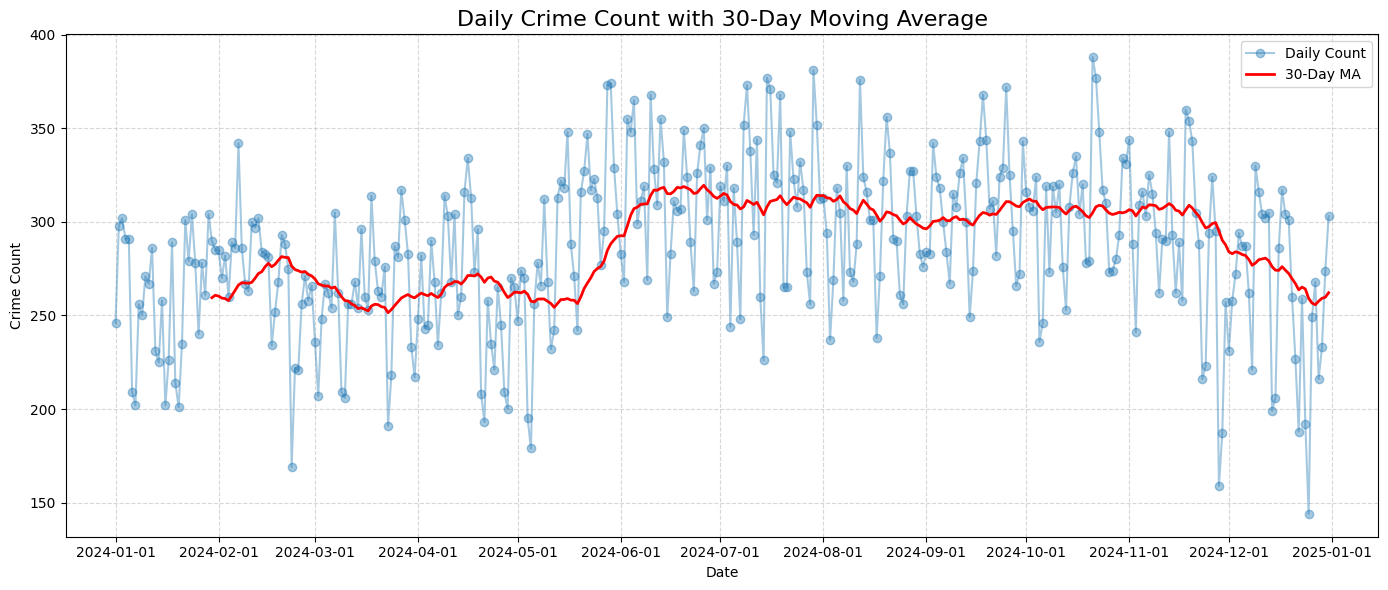

In [ ]:
import matplotlib.dates as mdates
from datetime import timedelta

# Count crimes per day
daily = crimes.groupby(crimes['dispatch_date_time'].dt.date).size().reset_index(name='crime_count')
daily['dispatch_date_time'] = pd.to_datetime(daily['dispatch_date_time'])

# Calculate 30-day moving average
daily['30d_ma'] = daily['crime_count'].rolling(window=30).mean()

plt.figure(figsize=(14,6))
plt.plot(daily['dispatch_date_time'], daily['crime_count'], marker='o', linestyle='-', alpha=0.4, label='Daily Count')
plt.plot(daily['dispatch_date_time'], daily['30d_ma'], color='red', linewidth=2, label='30-Day MA')

plt.title("Daily Crime Count with 30-Day Moving Average", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Crime Count")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Left/right padding
start_date = daily['dispatch_date_time'].min() - timedelta(days=15)
end_date = daily['dispatch_date_time'].max() + timedelta(days=15)
plt.xlim(start_date, end_date)

# Set monthly ticks and format
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

**Key Takeaways:**


1.   While the daily crime count alone provides limited insight into underlying trends, the 30-day moving average reveals a clear story: an upward shift starting in May, consistently high activity from June to October, and a steady decrease from November onward.

### 3.1.2 Weekly Crime Trend

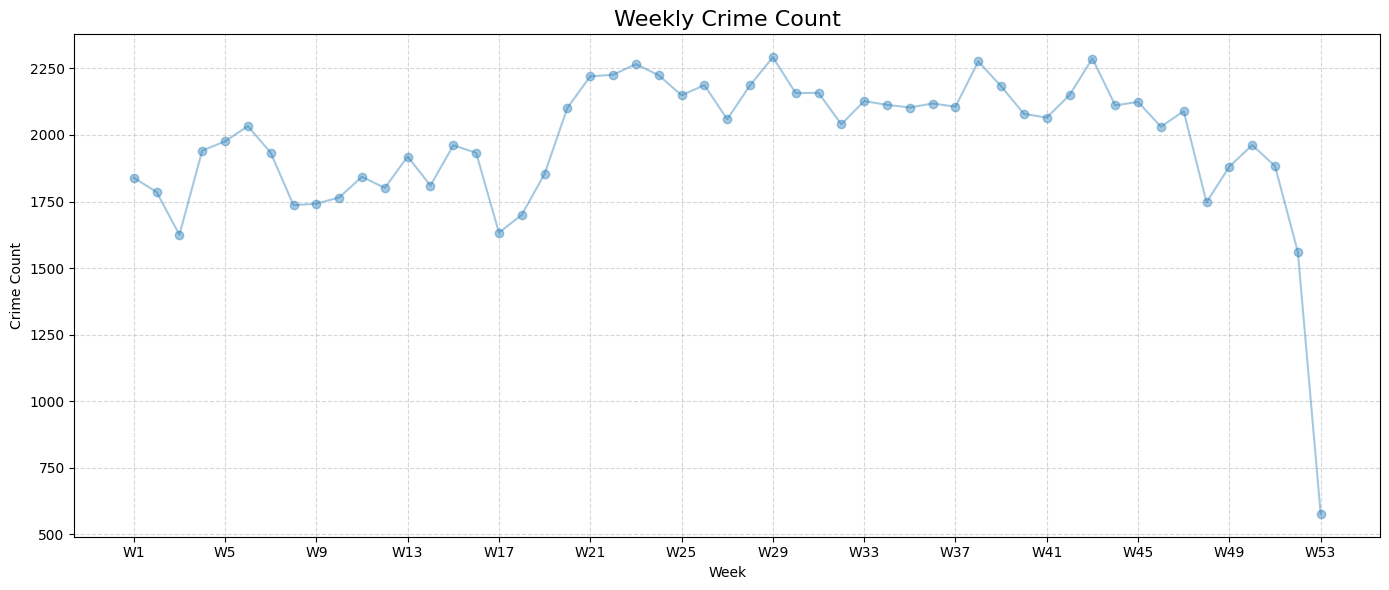

In [ ]:
import matplotlib.dates as mdates
from datetime import timedelta

# Count crimes per week
crimes['week'] = crimes['dispatch_date_time'].dt.to_period('W').dt.start_time
weekly = crimes.groupby('week').size().reset_index(name='crime_count')

# Add week number
weekly['week_num'] = range(1, len(weekly) + 1)

plt.figure(figsize=(14,6))
plt.plot(weekly['week_num'], weekly['crime_count'], marker='o', linestyle='-', alpha=0.4, label='Weekly Count')

plt.title("Weekly Crime Count", fontsize=16)
plt.xlabel("Week")
plt.ylabel("Crime Count")
plt.grid(True, linestyle='--', alpha=0.5)

# Set x-axis to show W1, W5, W9, etc. (every 4 weeks)
ax = plt.gca()
tick_positions = weekly['week_num'][::4]  # Every 4th week
ax.set_xticks(tick_positions)
ax.set_xticklabels([f'W{i}' for i in tick_positions])

plt.tight_layout()
plt.show()

**Key Takeaways:**


1.   The weekly crime count reaches its peak around W28 and generally remains elevated from W20 to W45, consistent with the pattern observed above.

2.   Notably, there is a sharp decrease in the final week of 2024.

### 3.1.3 Monthly Crime Trend

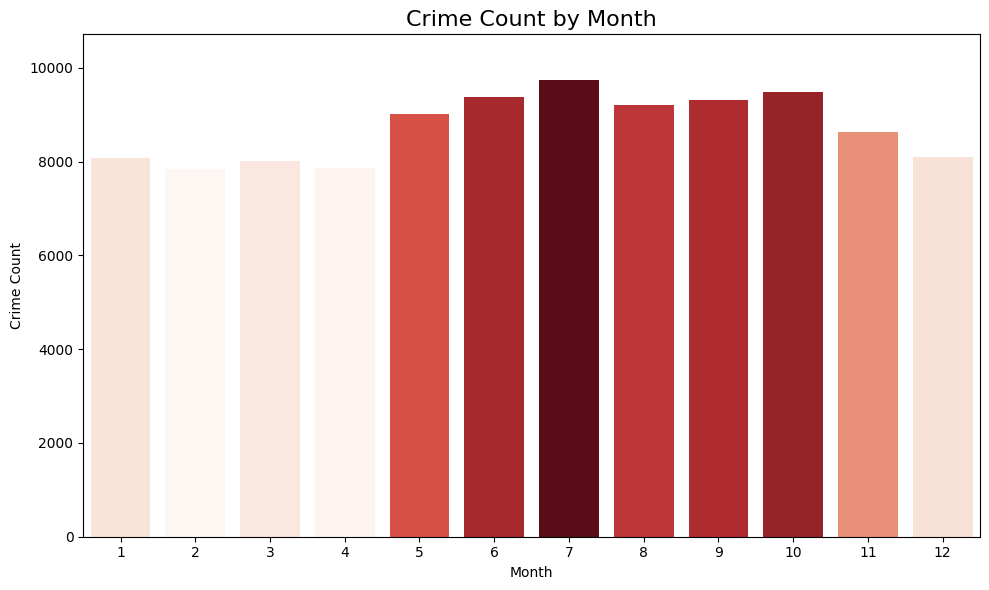

In [ ]:
# Extract month (1–12)
crimes['dispatch_month'] = crimes['dispatch_date_time'].dt.month

# Count crimes per month
monthly_counts = crimes.groupby('dispatch_month').size().reset_index(name='crime_count')

# Create Reds colormap
cmap = plt.get_cmap("Reds")
norm = mcolors.Normalize(
    vmin=monthly_counts['crime_count'].min(),
    vmax=monthly_counts['crime_count'].max()
)
colors = [cmap(norm(v)) for v in monthly_counts['crime_count']]

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=monthly_counts,
    x='dispatch_month',
    y='crime_count',
    palette=colors
)

# Extend y-axis for better visualization
y_max = monthly_counts['crime_count'].max()
plt.ylim(0, y_max * 1.1)

plt.title("Crime Count by Month", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Key Takeaways:**



1.   ncreases significantly starting in May, peaks during the summer months, and remains elevated through early autumn.
2.   A downward trend begins in November, suggesting lower crime activity moving into winter.





### 3.1.4 Seasonally Crime Trend

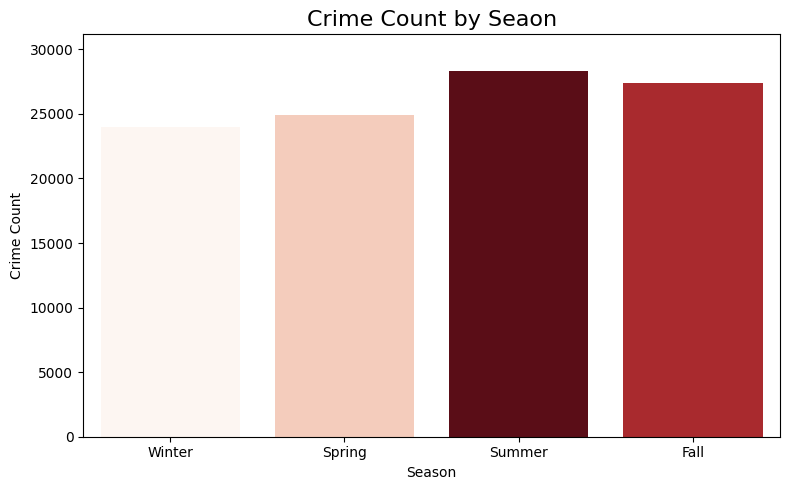

In [ ]:
# Map month to season
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

crimes['dispatch_season'] = crimes['dispatch_date_time'].dt.month.map(month_to_season)

# Count crimes per season
season_counts = crimes.groupby('dispatch_season').size().reset_index(name='crime_count')

# Optional: order seasons chronologically
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
season_counts['dispatch_season'] = pd.Categorical(season_counts['dispatch_season'], categories=season_order, ordered=True)
season_counts = season_counts.sort_values('dispatch_season')

# Create Reds colormap
cmap = plt.get_cmap("Reds")
norm = mcolors.Normalize(
    vmin=season_counts['crime_count'].min(),
    vmax=season_counts['crime_count'].max()
)
colors = [cmap(norm(v)) for v in season_counts['crime_count']]

# Plot
plt.figure(figsize=(8,5))
sns.barplot(
    data=season_counts,
    x='dispatch_season',
    y='crime_count',
    palette=colors
)

# Extend y-axis for better visualization
y_max = season_counts['crime_count'].max()
plt.ylim(0, y_max * 1.1)

plt.title("Crime Count by Seaon", fontsize=16)
plt.xlabel("Season")
plt.ylabel("Crime Count")
plt.tight_layout()
plt.show()

**Key Takeaways:**


1.   Crime incidents are highest in Summer, followed by Fall, and lowest in Winter.
2.   Overall, crime incidents are more frequent in the warm seasons than in Winter, suggesting a seasonal pattern in criminal activity.



### 3.1.5 Crime Count by Day of Week

After examining overall temporal trends across daily, weekly, monthly, and seasonal levels, we now take a closer look at how crime incidents vary within a typical week by analyzing the distribution of crimes across days of the week.

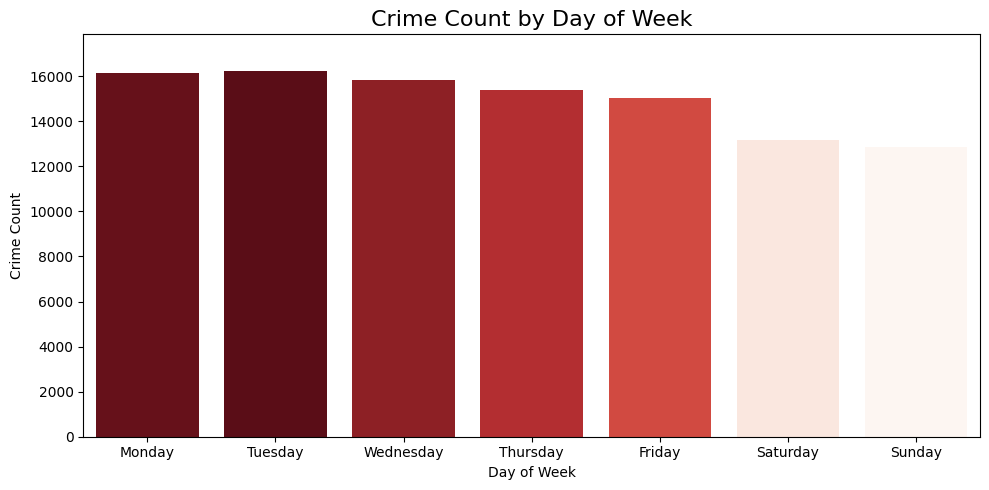

In [ ]:
# Extract weekday (0=Monday, 6=Sunday)
crimes['dispatch_weekday'] = crimes['dispatch_date_time'].dt.dayofweek

# Count crimes by weekday
weekday_counts = crimes.groupby('dispatch_weekday').size().reset_index(name='crime_count')

# Map weekday numbers to names
weekday_counts['weekday_name'] = weekday_counts['dispatch_weekday'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})

# Create Reds colormap
cmap = plt.get_cmap("Reds")
norm = mcolors.Normalize(
    vmin=weekday_counts['crime_count'].min(),
    vmax=weekday_counts['crime_count'].max()
)
colors = [cmap(norm(v)) for v in weekday_counts['crime_count']]

# Plot
plt.figure(figsize=(10,5))
sns.barplot(
    data=weekday_counts,
    x='weekday_name',
    y='crime_count',
    palette=colors,
    order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']  # keep weekday order
)

# Extend y-axis by ~10% above max value
y_max = weekday_counts['crime_count'].max()
plt.ylim(0, y_max * 1.1)

plt.title("Crime Count by Day of Week", fontsize=16)
plt.xlabel("Day of Week")
plt.ylabel("Crime Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Key Takeaways:**



1.   Tuesday has the highest number of crime incidents, followed closely by Monday.
2.   Crime counts gradually decline throughout the week, with the lowest levels observed on Saturday and Sunday.
3.   This pattern indicates that weekday crime incidents are higher at the start of the week and taper off toward the weekend.

### 3.1.6 Crime Count by Hour

After understanding how crime incidents vary across days of the week, we further break down the temporal granularity to examine crime patterns by hour of the day.

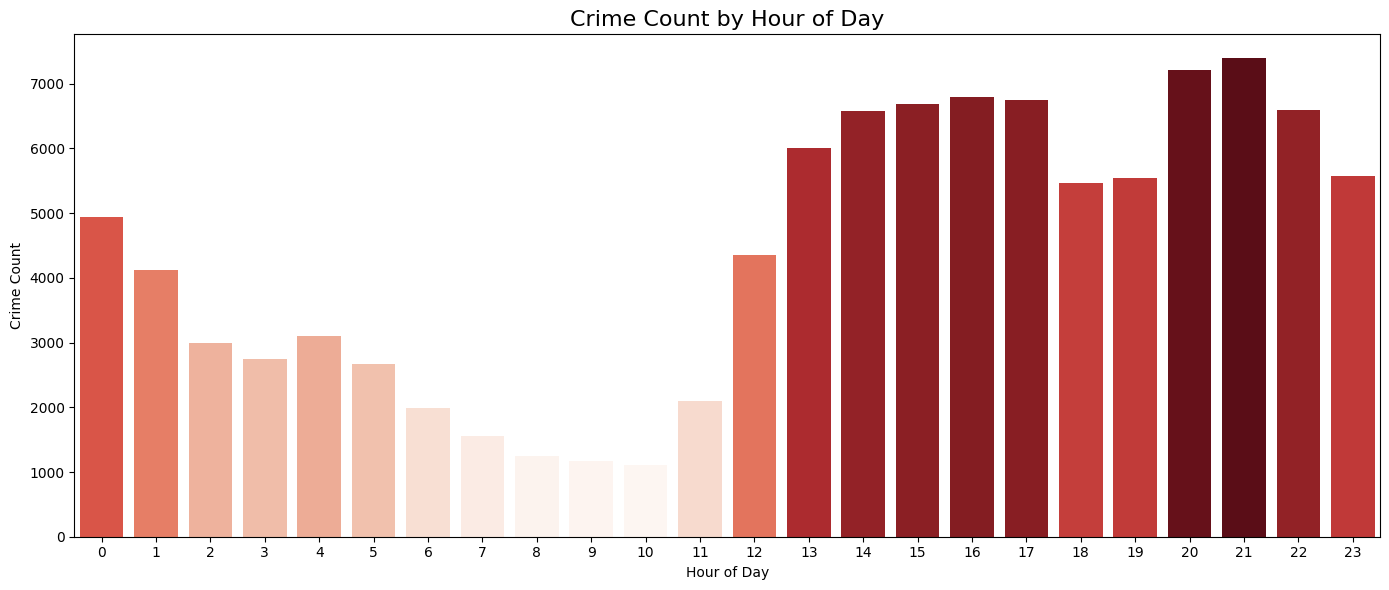

In [ ]:
# Extract hour
crimes['dispatch_hour'] = crimes['dispatch_date_time'].dt.hour

# Count crimes by hour
hourly = crimes.groupby('dispatch_hour').size().reset_index(name='crime_count')

# Sort by hour (0–23)
hourly = hourly.sort_values('dispatch_hour')

# Create Reds colormap
cmap = plt.get_cmap("Reds")

# Normalize using crime_count range
norm = mcolors.Normalize(
    vmin=hourly['crime_count'].min(),
    vmax=hourly['crime_count'].max()
)

# Map each hour to a color based on crime_count
colors = [cmap(norm(v)) for v in hourly['crime_count']]

# Plot with custom color palette
plt.figure(figsize=(14,6))
sns.barplot(
    data=hourly,
    x='dispatch_hour',
    y='crime_count',
    palette=colors
)

plt.title("Crime Count by Hour of Day", fontsize=16)
plt.xlabel("Hour of Day")
plt.ylabel("Crime Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Key Takeaways:**


1.  The majority of crime incidents occur during the afternoon and evening hours, with a steady increase from 13:00 through 21:00. Within this overall rising trend, a noticeable dip occurs between 18:00 and 19:00.
2.  Crime volume reaches its daily peak at 21:00.
3.  After the 21:00 peak, crime incidents gradually decline throughout the late-night hours.









## 3.2 Spatial Analysis

### 3.2.1 Crime Density Heatmap

To identify spatial hotspots across Philadelphia, we visualize all crime incidents using a geographic heatmap.
This map highlights high-density clusters of crime, revealing areas with consistent criminal activity regardless of time or crime type.

In [ ]:
# Create a base map centered on Philadelphia
m = folium.Map(location=[39.95, -75.16], zoom_start=12)

# Extract crime coordinate pairs (using cleaned dataframe: crimes)
heat_data = [
    [row['latitude'], row['longitude']]
    for _, row in crimes[['latitude', 'longitude']].dropna().iterrows()
]

# Add heatmap layer
HeatMap(heat_data, radius=7, blur=10, max_zoom=12).add_to(m)

m


**Key Takeaways:**

1. Identification of Crime Hotspots: The primary insight
from this heatmap is the clear visualization of crime hotspots. Areas that appear with more intense or saturated colors indicate a significantly higher density of crime incidents. These are geographical zones where criminal events are more frequent.

2. Spatial Clustering: The heatmap reveals that crime is not uniformly distributed across Philadelphia but rather exhibits spatial clustering. Certain neighborhoods or districts show distinct concentrations of incidents, suggesting underlying factors that contribute to elevated crime rates in those specific locales.

### 3.2.2 Crime Count by Police District (bar chart)

The color gradient of the bar chart matches the district-level choropleth map,
allowing direct visual comparison between the geographic map and the aggregated chart.
Districts with deeper red bars correspond to high-intensity crime zones observed in the map.

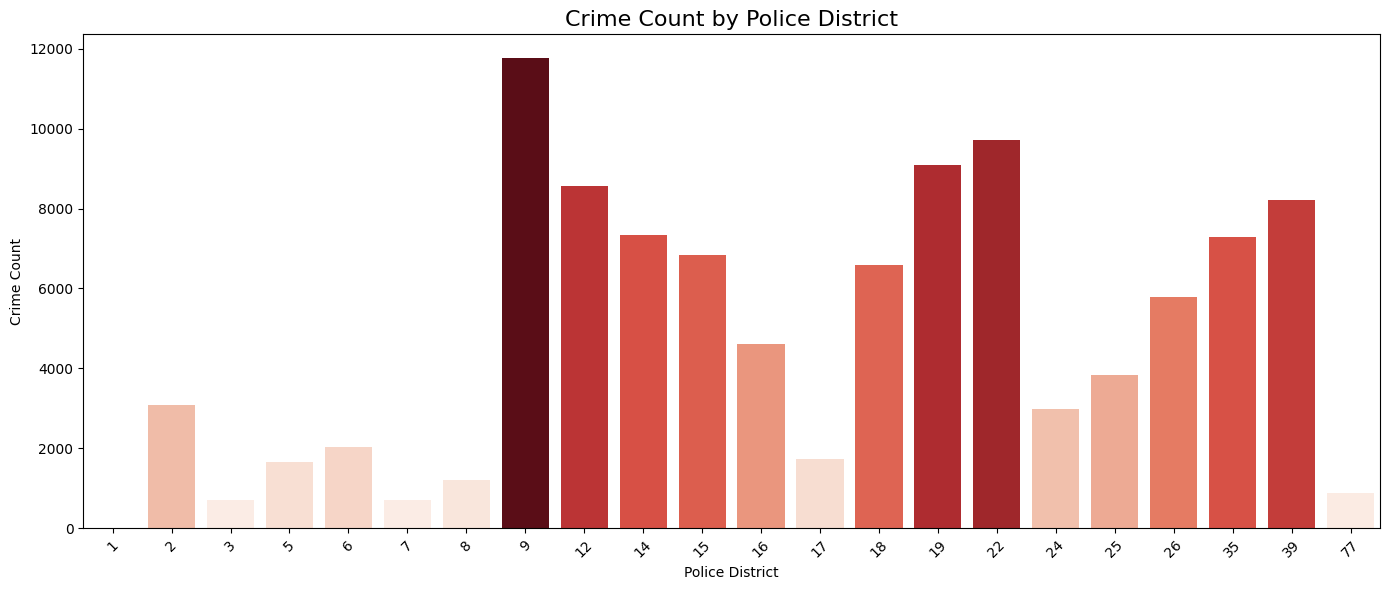

In [ ]:
# Aggregate crime count
district_counts = crimes.groupby('dc_dist').size().reset_index(name='crime_count')

# Create colormap
cmap = plt.get_cmap("Reds")

# Normalize based on crime counts
norm = mcolors.Normalize(
    vmin=district_counts['crime_count'].min(),
    vmax=district_counts['crime_count'].max()
)

# Create a mapping {district: color}
color_map = {
    row.dc_dist: cmap(norm(row.crime_count))
    for _, row in district_counts.iterrows()
}

# Now plot bar chart WITHOUT sorting, using colors tied to each district
plt.figure(figsize=(14,6))
sns.barplot(
    data=district_counts,
    x='dc_dist',
    y='crime_count',
    palette=[color_map[d] for d in district_counts['dc_dist']]
)

plt.title("Crime Count by Police District", fontsize=16)
plt.xlabel("Police District")
plt.ylabel("Crime Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Key Takeaways:**



3. Identification of High-Volume Districts: The chart explicitly highlights several districts as having significantly higher crime counts than others. For example, the top few districts stand out starkly from those at the lower end of the spectrum, indicating that crime is not evenly distributed but heavily concentrated in specific administrative zones.

4. District-Specific Focus for Interventions: For urban planners and law enforcement, this chart is invaluable as it points to specific police districts that require the most attention and resources. The high-crime districts indicated by the tallest bars would likely be targets for increased policing, community programs, or other crime reduction strategies.

1. Quantitative Ranking: The bar chart ranks police districts by total crime count, identifying high-crime areas like Districts 9, 22, and 19.

2. Visual Consistency: Colors in the bar chart match the choropleth map, reinforcing the geographical distribution of crime.

3. High-Volume Districts: The chart clearly highlights districts with significantly higher crime concentrations.
Targeted Interventions: This data is valuable for urban planners and law enforcement to direct resources to specific high-crime districts for interventions.


### 3.2.3 Crime Count by Police District (Choropleth Map)

To visualize the geographic distribution of crime across Philadelphia,
we overlay district-level crime totals onto the official Police District boundaries.
This allows us to identify which districts experience the highest incident volume
and provides the necessary spatial context before analyzing crime around transit stations.

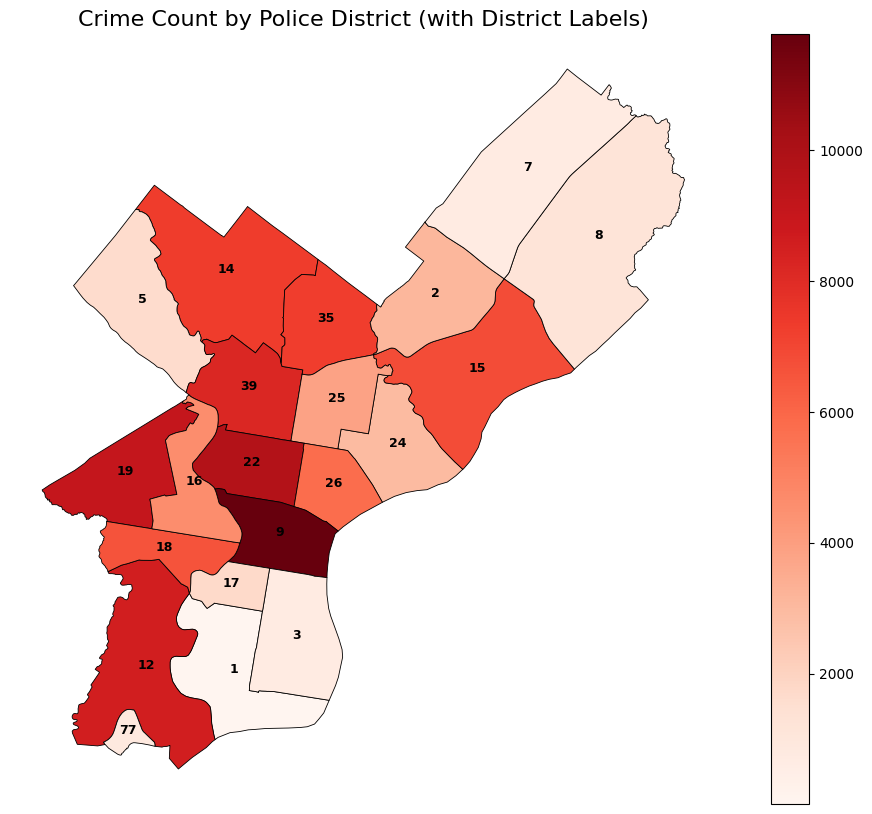

In [ ]:
# Load district boundaries
#districts = gpd.read_file('/content/drive/MyDrive/545_project/Boundaries_District.geojson')
districts = gpd.read_file('/content/drive/MyDrive/CIS 5450 - BDA/Final Project/Boundaries_District.geojson')
districts = districts.to_crs(epsg=4326)

# Load crime count per district
crime_by_dist = crimes.groupby('dc_dist').size().reset_index(name='crime_count')

# Standardize district key (common case: DIST_NUM column)
districts['dc_dist'] = districts['dist_numc'].astype(int)

# Merge crime data into boundary shapes
districts_merged = districts.merge(crime_by_dist, on='dc_dist', how='left')
districts_merged['crime_count'] = districts_merged['crime_count'].fillna(0)

# Plot choropleth
fig, ax = plt.subplots(figsize=(14, 10))

districts_merged.plot(
    column='crime_count',
    cmap='Reds',
    linewidth=0.6,
    edgecolor='black',
    legend=True,
    ax=ax
)

# Add district number labels at polygon centroids
for idx, row in districts_merged.iterrows():
    centroid = row['geometry'].centroid
    ax.text(
        centroid.x,
        centroid.y,
        str(row['dc_dist']),
        horizontalalignment='center',
        fontsize=9,
        fontweight='bold',
        color='black'
    )

ax.set_title("Crime Count by Police District (with District Labels)", fontsize=16)
ax.axis('off')

plt.show()


**Key Takeaways:**

1. Geographic Identification of High-Crime Areas: The most prominent feature of this map is its ability to visually pinpoint police districts with higher crime volumes. Districts colored with deeper shades of red indicate a significantly higher number of reported incidents, effectively acting as visual 'hotspots'. For example, districts 9, 22, and 19 clearly stand out as areas with the highest crime counts, consistent with the bar chart analysis.

2. Uneven Distribution of Crime: The map clearly demonstrates that crime is not uniformly spread across the city. Instead, it is concentrated in specific administrative zones, highlighting areas that may face greater socio-economic challenges or require more intensive law enforcement resources.

3. Spatial Context for Crime Analysis: By visualizing crime counts within their geographic boundaries, the map provides essential spatial context. This is critical for urban planning, resource allocation for policing, and developing targeted community interventions. Understanding where crime is happening helps in analyzing potential correlations with other geographic factors.

4. Complementary to Quantitative Data: While the bar chart provides precise numerical comparisons, the choropleth map offers an immediate geographic understanding. The visual correspondence between the two strengthens the overall analysis and confirms the consistency of the data representations.





### 3.2.4 Top 10 High-Risk Stations

This bar chart visualizes the stations with the highest number of crime incidents within 1500 meters.
These stations represent critical hotspots where public transit safety interventions may be most needed.

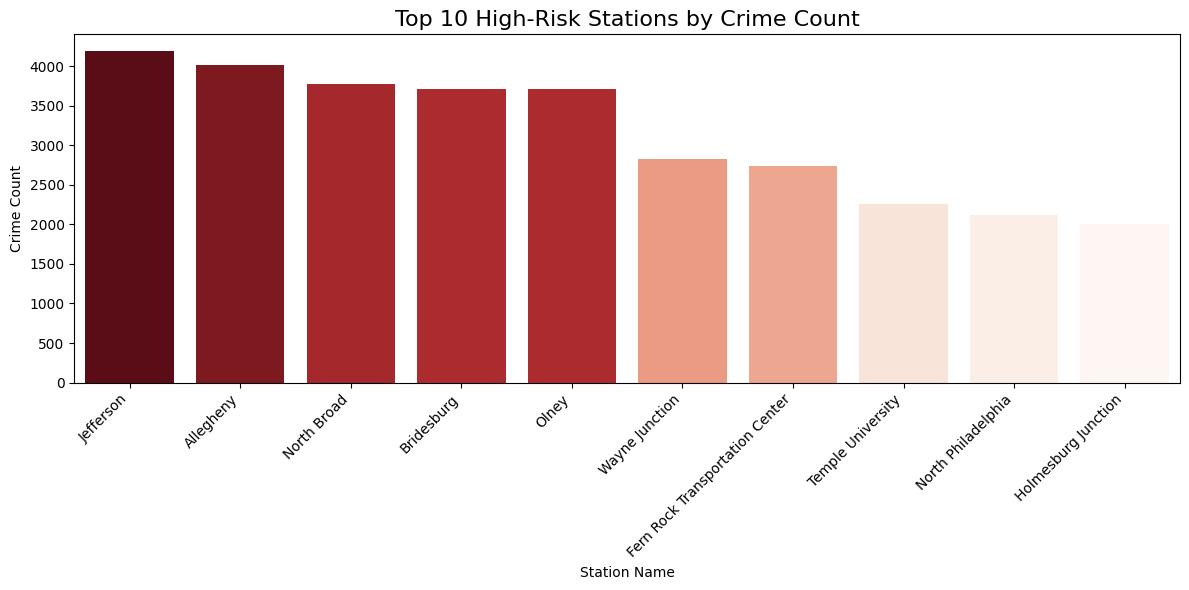

In [ ]:
# Get top 10 stations by crime count
top10 = stations.nlargest(10, 'crime_count').copy()

# Sort by crime_count descending
top10 = top10.sort_values('crime_count', ascending=False)

# Create Reds colormap
cmap = plt.get_cmap("Reds")

# Normalize based on crime_count range
norm = mcolors.Normalize(
    vmin=top10['crime_count'].min(),
    vmax=top10['crime_count'].max()
)

# Map each station to a color based on crime_count
colors = [cmap(norm(val)) for val in top10['crime_count']]

# Plot with custom color palette
plt.figure(figsize=(12,6))
sns.barplot(
    data=top10,
    x='station_name',
    y='crime_count',
    palette=colors
)

plt.xticks(rotation=45, ha='right')
plt.title("Top 10 High-Risk Stations by Crime Count", fontsize=16)
plt.xlabel("Station Name")
plt.ylabel("Crime Count")
plt.tight_layout()
plt.show()


**Key Takeaways:**

1. Identification of Critical Hotspots within the Transit System: This chart directly identifies the most problematic transit stations from a crime perspective. These are not merely general crime hotspots in the city, but specific nodes in the public transport infrastructure where crime concentration is highest. Understanding these locations is vital for transit authorities and law enforcement.

2. Magnitude of Crime Concentration: The height of each bar directly corresponds to the number of crime incidents associated with that particular station. This allows for a clear quantitative comparison, revealing not just which stations are high-risk, but how much more crime they experience compared to others. The use of a 'Reds' colormap, with deeper shades for higher counts, visually reinforces this magnitude.

3. Specific Station Names Highlighted: Unlike broader district-level analyses, this chart names the individual stations (e.g., '30th St Station', 'Market East Station') that are most affected. This specificity is invaluable for targeted interventions, security enhancements, and resource allocation efforts aimed at improving safety around these particular transit hubs.

4. Implications for Passenger Safety and Perceptions: Stations with persistently high crime counts can negatively impact passenger safety, ridership, and the overall perception of public transit security. This data can inform strategies to enhance security measures, such as increased police presence, improved lighting, or surveillance at these specific locations.

5. Data-Driven Decision Making: The ranking provided by this chart serves as a strong data point for decision-makers. It enables a prioritized approach to addressing crime within the transit system, focusing resources where they are most critically needed to have the greatest impact on reducing incidents.

## 3.3 Crime Type Analysis

### 3.3.1 Crime Category Distribution

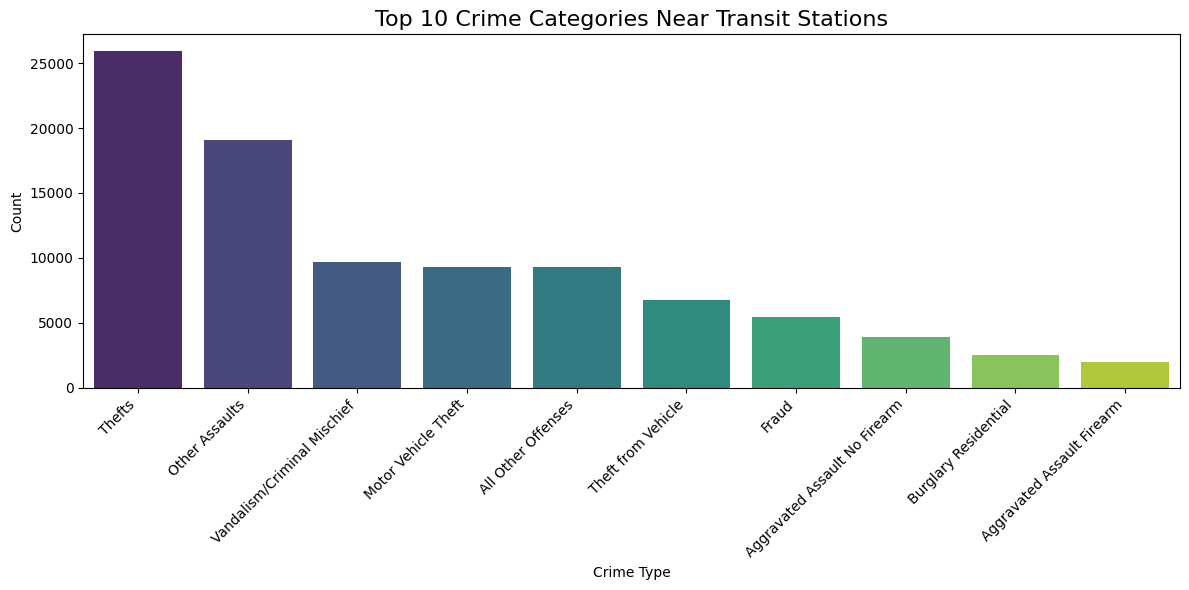

In [ ]:
# Aggregate counts by crime type
crime_type_counts = crimes['text_general_code'].value_counts().reset_index()
crime_type_counts.columns = ['crime_type', 'count']

# Optionally focus on top 10 categories
top_n = 10
crime_type_top = crime_type_counts.head(top_n)

plt.figure(figsize=(12,6))
sns.barplot(
    data=crime_type_top,
    x='crime_type',
    y='count',
    palette='viridis'
)
plt.xticks(rotation=45, ha='right')
plt.title(f"Top {top_n} Crime Categories Near Transit Stations", fontsize=16)
plt.xlabel("Crime Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Key Takeaways:

1. A small number of crime types (e.g., theft, assault, vandalism) account for most incidents near transit stations.

2. This concentration suggests that targeted interventions focused on the top few categories could have an outsized impact on overall station-area safety.

### 3.3.2 Crime Type vs Hour

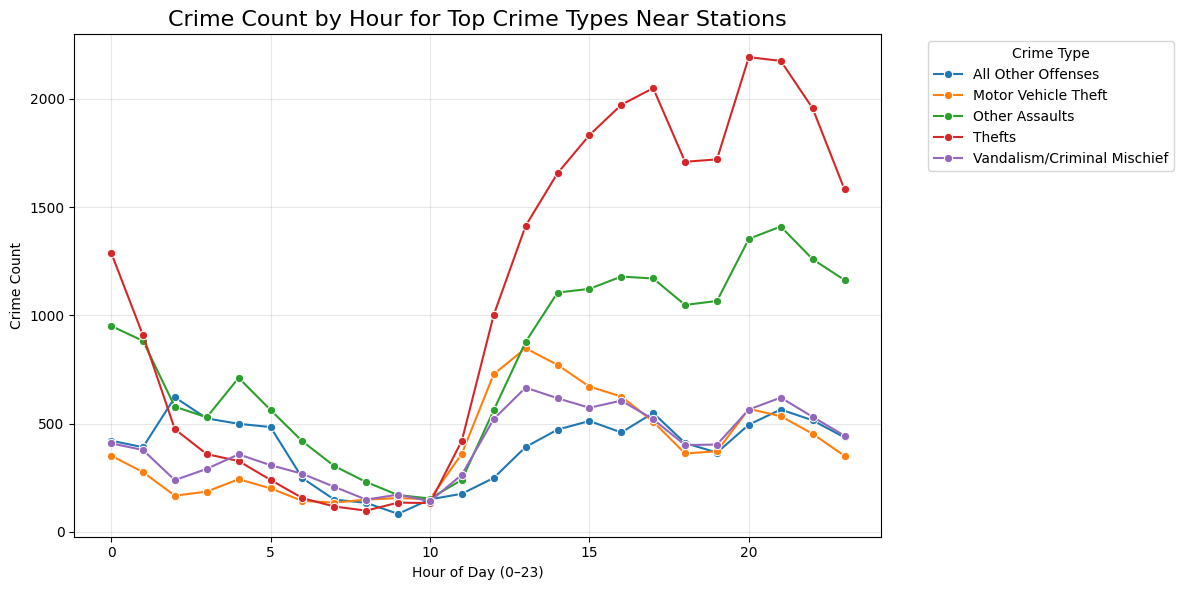

In [ ]:
# Create hour column if not already present
crimes['hour'] = crimes['dispatch_date_time'].dt.hour

# Focus on top 5 crime types
top_types = crime_type_counts.head(5)['crime_type'].tolist()
crimes_top = crimes[crimes['text_general_code'].isin(top_types)].copy()

# Group by hour and crime type
hour_type_counts = (
    crimes_top
    .groupby(['hour', 'text_general_code'])
    .size()
    .reset_index(name='count')
)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=hour_type_counts,
    x='hour',
    y='count',
    hue='text_general_code',
    marker='o'
)
plt.title("Crime Count by Hour for Top Crime Types Near Stations", fontsize=16)
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Crime Count")
plt.legend(title="Crime Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Key Takeaways:

1. Different crime types peak at different times of day (e.g., theft may spike during commuting hours, assaults later at night).

2. This suggests that temporal targeting (time-based policing, patrol scheduling) could be aligned with specific crime patterns around stations.

### 3.3.3 Crime Type vs District

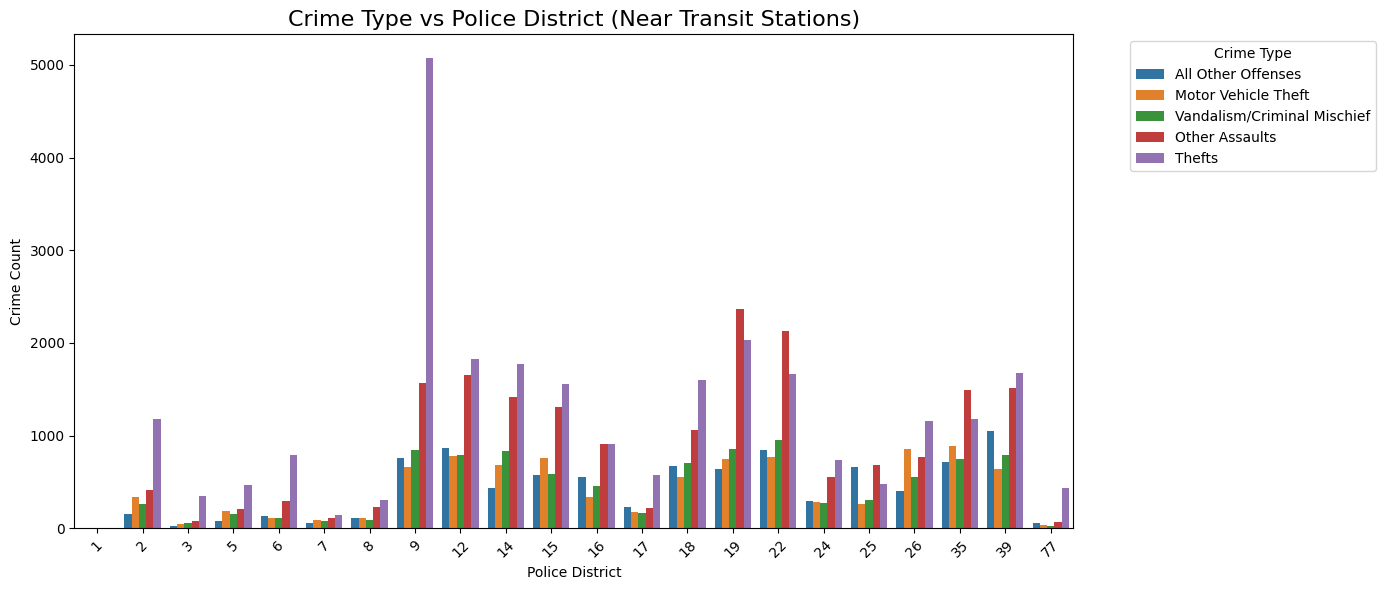

In [ ]:
# Stick with the same top crime types
crime_type_district = (
    crimes_top
    .groupby(['dc_dist', 'text_general_code'])
    .size()
    .reset_index(name='count')
)

plt.figure(figsize=(14,6))
sns.barplot(
    data=crime_type_district,
    x='dc_dist',
    y='count',
    hue='text_general_code'
)
plt.title("Crime Type vs Police District (Near Transit Stations)", fontsize=16)
plt.xlabel("Police District")
plt.ylabel("Crime Count")
plt.xticks(rotation=45)
plt.legend(title="Crime Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Key Takeaways:

1. The mix of crime types varies by district: some districts show more property crime, while others have relatively more violent incidents.

2. This indicates that station-area crime prevention strategies may need to be district-specific rather than one-size-fits-all.

## 3.4 Crime-Transit Relationship

### 3.4.1 Distance to Nearest Station Histogram

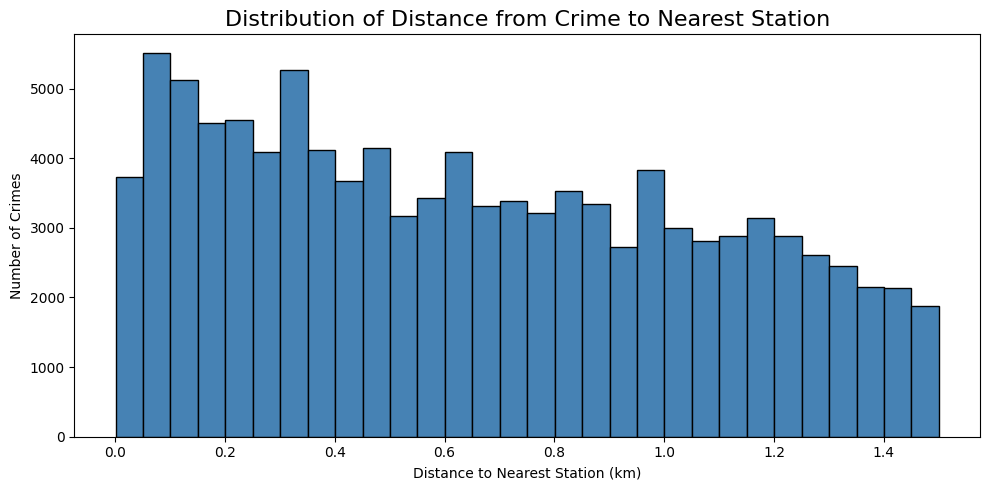

In [ ]:
# Convert meters to kilometers for interpretability
crimes['distance_km'] = crimes['distance_to_station'] / 1000.0

plt.figure(figsize=(10,5))
plt.hist(crimes['distance_km'], bins=30, color='steelblue', edgecolor='black')
plt.title("Distribution of Distance from Crime to Nearest Station", fontsize=16)
plt.xlabel("Distance to Nearest Station (km)")
plt.ylabel("Number of Crimes")
plt.tight_layout()
plt.show()


Key Takeaways:

1. Most crimes occur within a relatively short distance (e.g., < 1 km) of the nearest station.

2. This supports the idea that transit hubs are “anchor points” for nearby crime activity.

### 3.4.2 Crime Count vs Distance Scatterplot

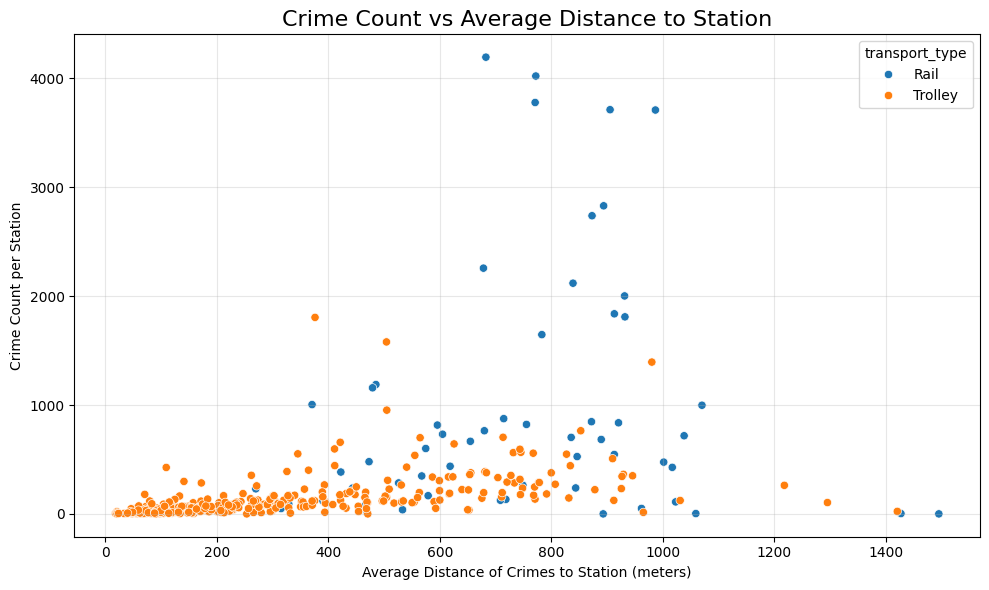

In [ ]:
# Aggregate station-level metrics from crimes
station_dist_stats = (
    crimes
    .groupby('assigned_station_id')
    .agg(
        crime_count=('assigned_station_id', 'size'),
        avg_distance_m=('distance_to_station', 'mean')
    )
    .reset_index()
)

# Merge with station info
station_dist_stats = station_dist_stats.merge(
    stations[['station_id', 'transport_type']],
    left_on='assigned_station_id',
    right_on='station_id',
    how='left'
)

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=station_dist_stats,
    x='avg_distance_m',
    y='crime_count',
    hue='transport_type'
)
plt.title("Crime Count vs Average Distance to Station", fontsize=16)
plt.xlabel("Average Distance of Crimes to Station (meters)")
plt.ylabel("Crime Count per Station")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Key Takeaways:

1. Stations with higher crime counts are generally surrounded by many incidents within a few hundred meters, showing that crime concentrates tightly around certain hubs.

2. There may be some stations with larger average distances and moderate crime, which could correspond to areas with more dispersed urban form.

### 3.4.3 Crime Count by Station Type

  transport_type    sum        mean  count
0           Rail  56076  359.461538    156
1        Trolley  48593   74.187786    655


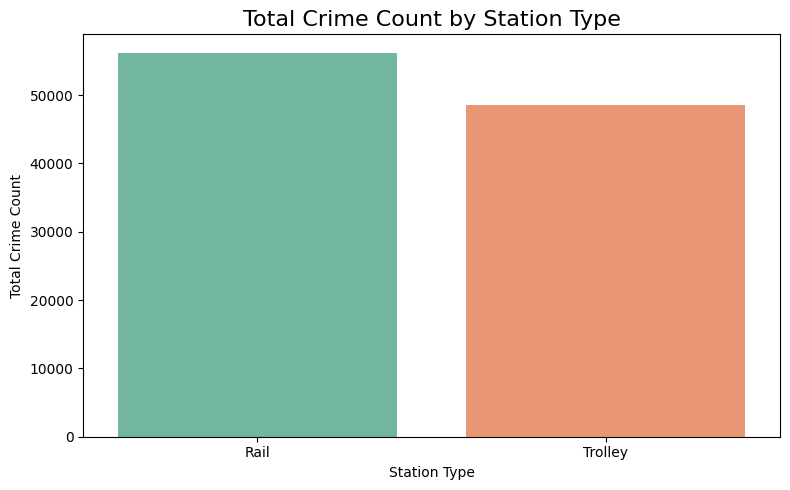

In [ ]:
station_type_counts = (
    stations
    .groupby('transport_type')['crime_count']
    .agg(['sum', 'mean', 'count'])
    .reset_index()
)

print(station_type_counts)

plt.figure(figsize=(8,5))
sns.barplot(
    data=stations,
    x='transport_type',
    y='crime_count',
    estimator=np.sum,
    ci=None,
    palette='Set2'
)
plt.title("Total Crime Count by Station Type", fontsize=16)
plt.xlabel("Station Type")
plt.ylabel("Total Crime Count")
plt.tight_layout()
plt.show()


Key Takeaways:

1. One station type (e.g., Rail vs Trolley) may account for a larger share of total crime near stations.

2. This could reflect differences in passenger volume, built environment, or policing strategies across transit modes.

### 3.4.4 Time Trend of Crimes Near Stations

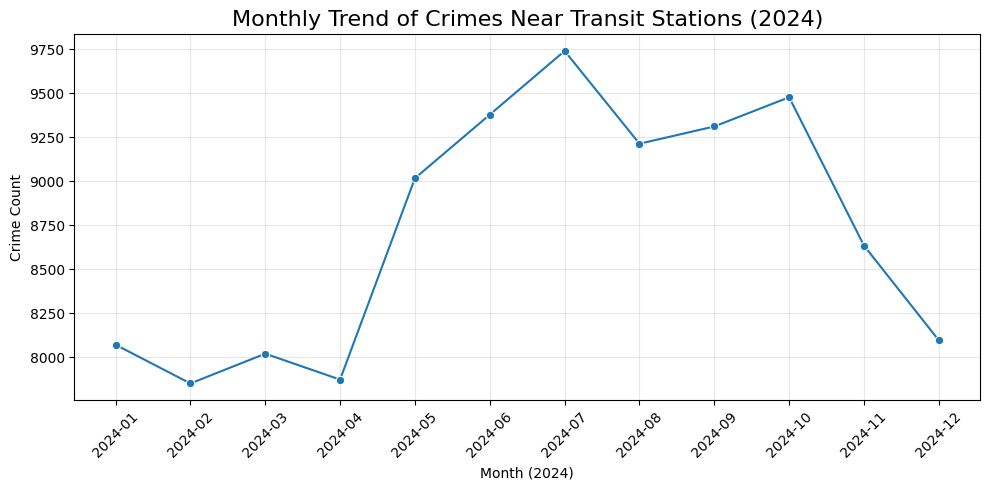

In [ ]:
# Create month column
crimes['month'] = crimes['dispatch_date_time'].dt.to_period('M').astype(str)

monthly_counts = (
    crimes
    .groupby('month')
    .size()
    .reset_index(name='crime_count')
    .sort_values('month')
)

plt.figure(figsize=(10,5))
sns.lineplot(
    data=monthly_counts,
    x='month',
    y='crime_count',
    marker='o'
)
plt.title("Monthly Trend of Crimes Near Transit Stations (2024)", fontsize=16)
plt.xlabel("Month (2024)")
plt.ylabel("Crime Count")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Key Takeaways:

1. Crime near stations exhibits a clear temporal trend across the year (e.g., higher in summer months, lower in winter).

2. This temporal pattern can be combined with ridership or event calendars to better understand what drives seasonal changes in transit-area crime.

### 3.4.5 Hotspot Overlay Map

In [ ]:
### 3.4.5 Hotspot Overlay Map

import folium
from shapely.ops import unary_union

# 1. Build a unified 1500m buffer around all stations (in projected CRS)
buffer_1500m = stations.buffer(1500)
stations_buffer_union = unary_union(buffer_1500m.geometry)

# Convert the unified buffer to WGS84 (lat/lon) for plotting in folium
stations_buffer_union_gdf = gpd.GeoDataFrame(
    geometry=[stations_buffer_union],
    crs=stations.crs
)
stations_buffer_union_wgs = stations_buffer_union_gdf.to_crs(epsg=4326)

# 2. Identify top 10 high-crime stations
top10 = stations.nlargest(10, 'crime_count').copy()
top10_names = set(top10['station_name'])

# Convert station geometries to WGS84 for mapping
stations_wgs = stations.to_crs(epsg=4326)

# 3. Base map centered on Philadelphia
m = folium.Map(location=[39.95, -75.16], zoom_start=12, tiles='cartodbpositron')

# 4. Add unified 1500m transit coverage polygon
folium.GeoJson(
    stations_buffer_union_wgs.geometry[0],
    style_function=lambda x: {
        "color": "blue",
        "weight": 2,
        "fillColor": "blue",
        "fillOpacity": 0.15
    },
    name="1500m Transit Coverage"
).add_to(m)

# 5. Add a sample of crime points (for performance, sample if very large)
crime_sample = crimes.sample(min(3000, len(crimes)), random_state=42)

for _, row in crime_sample.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='red',
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# 6. Add all stations, with top 10 highlighted in dark red
for _, row in stations_wgs.iterrows():
    name = row['station_name']
    lat = row.geometry.y
    lng = row.geometry.x
    crime_ct = int(row.get('crime_count', 0))

    if name in top10_names:
        # High-risk station
        folium.CircleMarker(
            location=[lat, lng],
            radius=6,
            color='darkred',
            fill=True,
            fill_opacity=1,
            popup=f"<b>High-Risk Station:</b> {name}<br>Crimes within 1500m: {crime_ct}"
        ).add_to(m)
    else:
        # Other stations
        folium.CircleMarker(
            location=[lat, lng],
            radius=3,
            color='gray',
            fill=True,
            fill_opacity=0.9,
            popup=f"Station: {name}<br>Crimes within 1500m: {crime_ct}"
        ).add_to(m)

folium.LayerControl().add_to(m)

m


Key Takeaways:

1. lear Identification of Crime Hotspots Near Transit:
The overlay map reveals that many crime incidents cluster tightly around transit-accessible areas. The blue 1,500m buffer highlights where stations influence surrounding neighborhoods, and most sampled crime points fall inside this zone.

2. High-Risk Stations Stand Out Visually:
The top 10 stations, shown in dark red, are surrounded by particularly dense clusters of crime incidents. These stations represent critical safety hotspots within the transit network and should be prioritized for targeted security interventions.

3. Crime Is Unevenly Distributed Within the Transit Buffer:
Although crimes frequently occur within station influence areas, the map shows that only certain locations experience heavy clustering. Many parts of the buffer have minimal crime, indicating that station proximity alone does not determine crime risk.

4. Transit Hubs Align with High-Activity Urban Areas:
Major interchange stations appear in the highest-risk group, suggesting that areas with high pedestrian flow, commercial density, and connectivity also experience more crime. This highlights the role of urban activity patterns in shaping crime concentration.

5. Guidance for Policy and Resource Allocation:
The map provides actionable information for transit agencies and city planners. High-risk stations identified in this visualization are strong candidates for enhanced surveillance, lighting improvements, and increased police or security presence.

6. Supports Further Modeling and Analysis:
The clear spatial clustering observed on the map validates our approach of linking crimes to stations. It also motivates feature engineering focused on distance, station type, and local neighborhood characteristics in later modeling steps.

# Part 4: Feature Engineering & Preprocessing

To identify station characteristics associated with higher crime rates, we aggregated crime data at the station level, with each station represented as a single observation. The features capture temporal patterns, crime type distributions, and variability in crime occurrences throughout 2024.

### 4.1. Feature Extraction

Before starting feature engineering, we merge `stations` and `crimes` dataframes to produce a unified dataset, called `stations_with_crimes`. This dataset integrates each station with its associated crime incidents, providing a comprehensive view of crime occurrences at every station.

In [ ]:
stations_with_crimes = pd.merge(
    stations.drop(['crime_count'], axis=1),
    crimes,
    left_on='station_id',
    right_on='assigned_station_id',
    how='left'
)

#### 4.1.1 Temporal Features


In order to capture temporal patterns in crime occurrences, we extracted time-related features These features include summary statistics of crime occurrence times and proportion-based measures that reflect the concentration of crimes during high-risk periods.

The features were extracted and their definitions are as follows:
*  `winter_ratio`: Proportion of crimes that occurred in winter (December, January, February) relative to total crimes at the station.
*  `spring_ratio`: Proportion of crimes that occurred in spring (March, April, May) relative to total crimes at the station.
*  `summer_ratio`: Proportion of crimes that occurred in summer (June, July, August) relative to total crimes at the station.
*  `fall_ratio`: Proportion of crimes that occurred in fall (September, October, November) relative to total crimes at the station.
*  `peak_ratio`: Proportion of crimes that occurred during the observed high-crime period (13:00-23:00) relative to total crimes at the station.


In [ ]:
# -----------------------------
# 1. Basic Time Feature Flags
# -----------------------------
# Season flags
stations_with_crimes['winter_flag'] = stations_with_crimes['dispatch_month'].isin([12, 1, 2]).astype(int)
stations_with_crimes['spring_flag'] = stations_with_crimes['dispatch_month'].isin([3, 4, 5]).astype(int)
stations_with_crimes['summer_flag'] = stations_with_crimes['dispatch_month'].isin([6, 7, 8]).astype(int)
stations_with_crimes['fall_flag'] = stations_with_crimes['dispatch_month'].isin([9, 10, 11]).astype(int)

# Peak hours flag (13:00-23:00)
stations_with_crimes['is_peak'] = stations_with_crimes['dispatch_hour'].between(13, 23).astype(int)

# -----------------------------
# 2. Station-Level Aggregation
# -----------------------------
station_features = (
    stations_with_crimes
    .groupby('station_id')
    .agg(
        # === Y: Target Variable ===
        total_crime_count=('station_id', 'count'),  # Total annual crimes

        # === Ratio Features (need intermediate calc) ===
        peak_crimes_tmp=('is_peak', 'sum'),
        winter_crimes_tmp=('winter_flag', 'sum'),
        spring_crimes_tmp=('spring_flag', 'sum'),
        summer_crimes_tmp=('summer_flag', 'sum'),
        fall_crimes_tmp=('fall_flag', 'sum'),
    )
    .reset_index()
)

# Compute ratio features
station_features['peak_ratio'] = (
    station_features['peak_crimes_tmp'] / station_features['total_crime_count']
)
station_features['winter_ratio'] = (
    station_features['winter_crimes_tmp'] / station_features['total_crime_count']
)
station_features['spring_ratio'] = (
    station_features['spring_crimes_tmp'] / station_features['total_crime_count']
)
station_features['summer_ratio'] = (
    station_features['summer_crimes_tmp'] / station_features['total_crime_count']
)
station_features['fall_ratio'] = (
    station_features['fall_crimes_tmp'] / station_features['total_crime_count']
)

# Drop temporary columns
station_features = station_features.drop(columns=[
    'peak_crimes_tmp', 'winter_crimes_tmp', 'spring_crimes_tmp', 'summer_crimes_tmp', 'fall_crimes_tmp'
])

#### 4.1.2 Crime Type Proportions Features

To capture the nature of criminal activity at each station, we computed the proportion of each major crime type. These features allow the model to distinguish stations based on their crime composition rather than volume alone.



We examined the distribution of crime types and found that the top 5 most frequent types account for 70% of all reported incidents. Based on this finding, we selected these 5 types to construct proportion-based features, ensuring sufficient coverage while avoiding sparse features from rare crime types.

In [ ]:
# The ditrubution of crime types
crime_distribution = stations_with_crimes['text_general_code'].value_counts()
print(f"Total crime types: {len(crime_distribution)}")
print(f"\nTop 5 crime types:")
print(crime_distribution.head(5))
print()
print(f"Top 5 covers: {crime_distribution.head(5).sum() / crime_distribution.sum() * 100:.1f}% of all crimes")

Total crime types: 31

Top 5 crime types:
text_general_code
Thefts                         25915
Other Assaults                 19044
Vandalism/Criminal Mischief     9652
Motor Vehicle Theft             9312
All Other Offenses              9300
Name: count, dtype: int64

Top 5 covers: 70.0% of all crimes


The features were extracted and their definitions are as follows:
*  `pct_Thefts`: Proportion of theft-related crimes among the top 5 crime types at the station.
*  `pct_Other Assaults`: Proportion of assault-related crimes among the top 5 crime types at the station.
*  `pct_Vandalism/Criminal Mischief`: Proportion of vandalism crimes among the top 5 crime types at the station.
*  `pct_Motor Vehicle Theft`: Proportion of motor vehicle theft crimes among the top 5 crime types at the station.
*  `pct_All Other Offenses`: Proportion of other miscellaneous offenses among the top 5 crime types at the station.

In [ ]:
# Get top 10 crime types (covers ~90% of all crimes)
top_crime_types = (
    stations_with_crimes['text_general_code']
    .value_counts()
    .nlargest(5)
    .index.tolist()
)

# Count crimes per station per crime type
crime_type_counts = (
    stations_with_crimes[stations_with_crimes['text_general_code'].isin(top_crime_types)]
    .groupby(['station_id', 'text_general_code'])
    .size()
    .reset_index(name='count')
)

# Pivot to wide format
crime_type_pivot = crime_type_counts.pivot_table(
    index='station_id',
    columns='text_general_code',
    values='count',
    fill_value=0
).reset_index()

# Compute crime type proportions
crime_cols = [c for c in top_crime_types if c in crime_type_pivot.columns]
for c in crime_cols:
    crime_type_pivot[f'pct_{c}'] = (
        crime_type_pivot[c] / crime_type_pivot[crime_cols].sum(axis=1).replace(0, 1)
    )

# Keep only proportion columns
pct_cols = ['station_id'] + [f'pct_{c}' for c in crime_cols]
crime_type_pivot = crime_type_pivot[pct_cols]

#### 4.1.3 Variability Features

To measure the stability of crime patterns over time, we calculated the coefficient of variation for monthly crime counts. This feature captures whether a station experiences consistent crime levels or irregular fluctuations throughout the year.

The features were extracted and their definitions are as follows:
*  `monthly_cv`: Coefficient of variation of monthly crime counts, calculated as the standard deviation divided by the mean. Higher values indicate more irregular crime patterns across months, while lower values suggest stable, consistent crime levels.

In [ ]:
monthly_counts = (
    stations_with_crimes
    .groupby(['station_id', 'dispatch_month'])
    .size()
    .reset_index(name='monthly_count')
)

# Compute coefficient of variation only
monthly_stats = monthly_counts.groupby('station_id')['monthly_count'].agg(['mean', 'std']).reset_index()
monthly_stats['monthly_cv'] = monthly_stats['std'] / (monthly_stats['mean'] + 1e-6)
monthly_stats = monthly_stats[['station_id', 'monthly_cv']]


Finally, we combined all extracted features into one data frame, called `station_with_features` for further processing and analysis.

In [ ]:
station_with_features = (
    station_features
    .merge(crime_type_pivot, on='station_id', how='left')
    .merge(monthly_stats, on='station_id', how='left')
    .fillna(0)
)

### 4.2. Create Training & Test Data

Since our machine learning model requires separate training and testing datasets, we opted for an 80/20 train-test split—a common and reasonable starting point.

To ensure our results are reproducible, we fixed the random seed at 42, following the same pseudo-random approach we used in our homework exercises.

In [ ]:
# Train-test split
X = station_with_features.drop(columns=['total_crime_count', 'station_id'])
y = station_with_features['total_crime_count']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 4.3. Standardization

Before applying PCA, we have to standardize the features to have zero mean and unit variance because PCA is not scale-invariant. By scaling all features to a comparable range, we ensure that no single feature dominates due to its numerical magnitude.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initializing scaler
scaler = StandardScaler()

# Fit scaler only on train set
X_train_scaled = scaler.fit_transform(X_train)

# Transform test set using the same scaler
X_test_scaled = scaler.transform(X_test)

### 4.4. PCA

We further applied PCA to reduce dimensionality and capture the main patterns in the data. This reduces noise, captures dominant crime patterns, and provides a more informative, lower-dimensional feature set for modeling.

In [ ]:
from sklearn.decomposition import PCA

# -----------------------------
# 1. Apply PCA on train set
# -----------------------------
# Keep enough components to explain 95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)  # use the same PCA model

print(f"\nOriginal number of features: {X.shape[1]}")
print(f"Number of PCA components: {X_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

# -----------------------------
# 2. Convert PCA Result to DataFrame
# -----------------------------
pca_cols = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
train_pca_df = pd.DataFrame(X_train_pca, columns=pca_cols)
train_pca_df['station_id'] = X_train.index
train_pca_df['total_crime_count'] = y_train.values

test_pca_df = pd.DataFrame(X_test_pca, columns=pca_cols)
test_pca_df['station_id'] = X_test.index
test_pca_df['total_crime_count'] = y_test.values

# Train PCA DataFrame preview
print("\nPCA DataFrame preview:")
print(train_pca_df.head())


Original number of features: 11
Number of PCA components: 8
Explained variance ratio: 0.9711

PCA DataFrame preview:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  2.208857 -4.792247 -3.243122 -5.394183 -0.381123  1.588998  4.412686   
1 -2.904415  0.015182 -0.036824 -0.002092 -0.008855 -0.015433 -0.003092   
2  2.460623 -3.050730 -0.985553 -3.146463  0.886535 -0.491693 -0.327428   
3  1.755929 -0.480169  2.810663 -0.193763 -0.382266  0.001299 -0.398935   
4  1.863585 -1.065441  0.965062 -0.063045  0.419161  0.105992 -0.164112   

        PC8  station_id  total_crime_count  
0  0.381803           1                  1  
1 -0.008950           2                  1  
2 -1.162092           3                 98  
3  0.100726           4                837  
4  0.027893           5                546  


**Results of PCA:**

After applying PCA, we retained 8 principal components, which together explain approximately 97.11% of the variance in the data. This means that with these 8 components, we capture almost all the information from the original features while reducing dimensionality, making the dataset more compact and suitable for modeling.

#Part 5: Modeling - 1

Our modeling in here began with Linear Regression to predict exact crime counts using PCA features, but its limited R² showed weak predictive power for precise values. We then reframed the task as classification with Logistic Regression, categorizing stations into high-crime vs. low-crime to provide more operational insight. Although accuracy was moderate, low recall for high-crime stations revealed the need to further address class imbalance to better detect high-risk areas.


## 5.1 Linear Regression

This section builds a baseline predictive model to estimate crime counts using the PCA-derived station features. First, the dataset is split into training and testing subsets to ensure an unbiased evaluation of model performance. A linear regression model is then fitted using the principal components as predictors, and its accuracy is assessed with RMSE and R² on both the training and test sets. These metrics serve as a reference point for comparing future, more complex models.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# ---------------------------
# Fit Linear Regression
# ---------------------------
lin_reg = LinearRegression()
lin_reg.fit(X_train_pca, y_train)

# ---------------------------
# Predictions
# ---------------------------
y_pred_train = lin_reg.predict(X_train_pca)
y_pred_test  = lin_reg.predict(X_test_pca)

# ---------------------------
# Evaluation Metrics
# ---------------------------

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse  = mean_squared_error(y_test, y_pred_test)

train_rmse = np.sqrt(train_mse)
test_rmse  = np.sqrt(test_mse)

train_r2 = r2_score(y_train, y_pred_train)
test_r2  = r2_score(y_test, y_pred_test)

print("===== Linear Regression Baseline =====")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE:  {test_rmse:.2f}")
print(f"Train R²:   {train_r2:.4f}")
print(f"Test R²:    {test_r2:.4f}")

===== Linear Regression Baseline =====
Train RMSE: 349.52
Test RMSE:  495.85
Train R²:   0.1257
Test R²:    0.0868


**Key Takeaways for Linear Regression:**

1.  **Limited Explanatory Power:** The R² values are very low for both the training (0.1257) and test (0.0868) sets. This indicates that the Linear Regression model explains only a small fraction of the variance in `total_crime_count`, suggesting that the current PCA features do not have a strong linear relationship with the actual crime counts.
2.  **High Prediction Errors:** The Root Mean Squared Error (RMSE) values are notably high (Train RMSE: 349.52, Test RMSE: 495.85). These large errors suggest that the model's predictions are, on average, quite far from the true crime counts. This makes the model unreliable for precise quantitative predictions.
3.  **Baseline for Comparison:** While the model provides a quantitative baseline, its poor performance highlights the limitations of using a simple linear approach to predict exact crime counts with the current feature set. This outcome motivated the transition to a classification approach, aiming for more actionable insights by categorizing stations into high-crime vs. low-crime rather than predicting precise numerical values.

## 5.2 Logistic Regression

This section reframes crime prediction as a binary classification task by labeling stations in the top 25% of crime incidents as **high-crime**. Logistic Regression is then trained using PCA-derived features to determine whether a station belongs to the high-crime category. Evaluation metrics such as accuracy, precision, recall, and F1 score are reported to assess how well the model detects high-risk stations and to highlight limitations the low recall rate, which indicates that many true high-crime stations remain undetected.

In [ ]:
# ---------------------------
# 1. Create Binary Target Variable
# ---------------------------
# Define top 25% as high crime stations
threshold = station_with_features['total_crime_count'].quantile(0.75)
station_with_features['high_crime'] = (station_with_features['total_crime_count'] > threshold).astype(int)

# ---------------------------
# 2. Use the same train-test split as before
# ---------------------------
y_train = station_with_features.loc[y_train.index, 'high_crime']
y_test  = station_with_features.loc[y_test.index, 'high_crime']

# Print high/low crime counts in training set
num_high_train = y_train.sum()
num_low_train  = (y_train == 0).sum()

print(f"High crime stations (1): {num_high_train}")
print(f"Low crime stations (0): {num_low_train}")

# ---------------------------
# 3. Fit Logistic Regression using precomputed PCA
# ---------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_pca, y_train)

# Predictions
y_pred_train = log_reg.predict(X_train_pca)
y_pred_test  = log_reg.predict(X_test_pca)

# ---------------------------
# 4. Evaluation Metrics
# ---------------------------
print("\n===== Logistic Regression Results =====")
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test Accuracy:  {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Test Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"Test Recall:    {recall_score(y_test, y_pred_test):.4f}")
print(f"Test F1 Score:  {f1_score(y_test, y_pred_test):.4f}")

High crime stations (1): 203
Low crime stations (0): 608

===== Logistic Regression Results =====
Train Accuracy: 0.7701
Test Accuracy:  0.7730
Test Precision: 0.6250
Test Recall:    0.2439
Test F1 Score:  0.3509


**Key Takeaways for Logistic Regression:**

1.  **Class Imbalance:** The dataset shows a significant class imbalance, with 203 high-crime stations and 608 low-crime stations. This imbalance can heavily influence model performance, especially metrics like recall for the minority class.
2.  **Moderate Accuracy:** The model achieved a Test Accuracy of 0.7730, indicating that it correctly classifies about 77.3% of stations overall. While seemingly good, accuracy alone can be misleading in the presence of class imbalance.
3.  **Good Precision, Low Recall for High-Crime Stations:**
    *   **Test Precision: 0.6250:** This means that when the model predicts a station is 'high-crime', it is correct 62.5% of the time. This is a reasonably good score, suggesting that the stations identified as high-risk are often genuinely so.
    *   **Test Recall: 0.2439:** This is a crucial metric, and its low value (24.39%) indicates a significant limitation. It means that out of all the stations that are *truly* high-crime, the model only managed to identify about a quarter of them. A large proportion of actual high-crime stations are being missed.
4.  **Low F1 Score:** The Test F1 Score of 0.3509, which is the harmonic mean of precision and recall, is relatively low. This suggests poor overall performance in effectively identifying high-crime stations, primarily driven by the low recall.

## 5.3 Conclusion: Why We Shifted to a Classification Model

Our initial regression approach attempted to predict annual crime counts per station. However, the model performed poorly (R² < 0.20), indicating that our available features cannot sufficiently explain the large cross-station variability in crime intensity. Since we lack critical neighborhood-level factors such as population density, built environment attributes, or socioeconomic indicators, improving the regression accuracy is structurally limited.

Given these constraints, we shifted to a classification framework, labeling stations as high-risk versus low-risk. Classification is more robust under limited feature availability and provides more actionable insights for identifying priority stations. However, the crime-risk classes are imbalanced, which weakens model recall. Therefore, we plan to incorporate SMOTE to generate a balanced training set and enable the classifier to better identify high-risk stations.

#Part 6: Modeling - 2

According to the findings from Part 5: Modeling – 1, we decided to focus on building classification models in the following analysis to evaluate which algorithm delivers the strongest predictive performance. Specifically, we will develop **four baseline models—Logistic Regression, Random Forest, XGBoost and Neural Networks—using the original training data in Part 6.1.**

In addition to the baseline models, we aim to assess whether addressing class imbalance can further improve model performance. To do so, we **apply SMOTE to generate a more balanced training set and rebuild the same three models on the SMOTE-enhanced data in Part 6.2**. Comparing the results of the baseline models and their SMOTE counterparts allows us to understand the impact of oversampling on classification accuracy and robustness.

## 6.1 Baseline Classification Models

#### 6.1.1 Logistic Regression

We selected Logistic Regression as our initial classification model because it provides a clear and interpretable baseline for distinguishing high-crime stations from low-crime stations. Given that our feature set is relatively limited and primarily derived from spatial and temporal characteristics, Logistic Regression allows us to evaluate whether the available features contain any meaningful signal for classification before moving to more complex models. Its simplicity, transparency, and low risk of overfitting make it an appropriate first step for understanding the structure of our data and establishing a benchmark for model performance.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Fit Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_pca, y_train)

# 2. Predictions & Evaluation
y_pred = log_reg.predict(X_test_pca)

print("===== Logistic Regression Results =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


===== Logistic Regression Results =====
Accuracy: 0.7730061349693251
Precision: 0.625
Recall: 0.24390243902439024
F1 Score: 0.3508771929824561


**Key Takeaways for Logistic Regression:**

The Logistic Regression model provides a baseline for predicting high-crime instances but shows limited predictive power. Its performance is notably lower compared to more complex models, particularly in identifying actual high-crime stations.

1. Accuracy (77.3%) – The model correctly classifies about 77.3% of stations overall. While this seems moderate, it can be misleading due to class imbalance where low-crime stations are more numerous.

2. Precision (62.5%) – When the model predicts a station is 'high-crime', it is correct 62.5% of the time. This indicates that a significant portion of its positive predictions are accurate.

3. Recall (24.4%) – This is a critical limitation. The model identifies only about 24.4% of all truly high-crime stations, meaning a large number of high-risk areas are missed. This low recall is a major concern when the goal is to detect as many high-risk stations as possible.

4. F1 Score (0.351) – The F1 score, which balances precision and recall, is low. This reflects the model's overall poor effectiveness in correctly identifying high-crime stations, primarily driven by its low recall.

#### 6.1.2 Random Forest

In addition to Logistic Regression, we also applied a Random Forest model to our classification task.

Random Forest is an ensemble learning method that builds multiple decision trees and aggregates their predictions, which generally improves robustness and accuracy. By using Random Forest, we aim to capture complex, non-linear relationships in the data that simpler models, such as Logistic Regression, may not fully exploit.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 1. Fit Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight=None
)
rf_model.fit(X_train_pca, y_train)

# 2. Predictions & Evaluation
y_pred = rf_model.predict(X_test_pca)

print("===== Random Forest Results =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


===== Random Forest Results =====
Accuracy: 0.9263803680981595
Precision: 0.8717948717948718
Recall: 0.8292682926829268
F1 Score: 0.85


**Key Takeaways for Random Forest**:

The Random Forest model clearly outperforms Logistic Regression in predicting high-crime instances.

Compared to Logistic Regression, which suffers from low recall and F1 score, Random Forest achieves much higher overall performance across all key metrics.
1. Accuracy (92.6%) – The model correctly classifies the majority of instances, indicating strong overall performance.

2. Precision (87.2%) – When predicting high-crime instances, the model is correct about 87% of the time, reflecting relatively few false positives.

3. Recall (82.9%) – The model identifies the majority of actual high-crime cases, significantly improving coverage compared to Logistic Regression.

4. F1 Score (0.85) – The balance between precision and recall is strong, showing that the model effectively captures high-crime instances while minimizing errors.

#### 6.1.3 XGBoost

In addition to Random Forest, we also applied an XGBoost model to our classification task.

XGBoost is an advanced gradient boosting algorithm that builds an ensemble of decision trees sequentially, where each tree attempts to correct the errors of the previous ones.
By including XGBoost in our analysis, we aim to leverage its ability to capture complex, non-linear patterns and interactions in the data.

In [ ]:
from xgboost import XGBClassifier

# 1. Fit XGBoost
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)
xgb_model.fit(X_train_pca, y_train)

# 2. Predictions & Evaluation
y_pred = xgb_model.predict(X_test_pca)

print("===== XGBoost Results =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


===== XGBoost Results =====
Accuracy: 0.9141104294478528
Precision: 0.813953488372093
Recall: 0.8536585365853658
F1 Score: 0.8333333333333334


**Key Takeaways for XGBoost**:

XGBoost outperforms Logistic Regression and performs comparably to Random Forest in predicting high-crime instances.

Compared to Logistic Regression, which suffers from low recall and F1 score, XGBoost achieves much higher overall performance across all key metrics. While Random Forest shows slightly higher precision, XGBoost achieves slightly higher recall, indicating it is very effective at identifying high-crime stations.

1. Accuracy (91.4%) – The model correctly classifies about 91.4% of instances, showing strong overall performance, slightly lower than Random Forest (92.6%) but much higher than Logistic Regression (77.3%).

2. Precision (81.4%) – When predicting high-crime instances, the model is correct about 81% of the time, slightly lower than Random Forest (87.2%) but considerably better than Logistic Regression (62.5%).

3. Recall (85.4%) – The model identifies the majority of actual high-crime cases, slightly higher than Random Forest (82.9%) and much higher than Logistic Regression (24.4%), highlighting its strong coverage of high-crime stations.

4. F1 Score (0.83) – The balance between precision and recall is strong, slightly lower than Random Forest (0.85) but far better than Logistic Regression (0.35), demonstrating effective detection of high-crime instances.

####　6.1.4 Neural Networks

In addition to traditional machine learning models, we also implemented a Neural Network using a Multi-Layer Perceptron (MLP) architecture.

Neural Networks are capable of learning complex, non-linear relationships in the data through multiple layers of interconnected neurons. By applying an MLP, we aim to capture intricate patterns and interactions between features that may be difficult for tree-based or linear models to detect.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 1. Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 2. Define MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

input_dim = X_train_tensor.shape[1]
model = MLP(input_dim)

# 5. Loss & optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 6. Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {epoch_loss:.4f}")

# 7. Predictions & Evaluation
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).numpy()
    y_pred = (y_pred_prob >= 0.5).astype(int)

print("\n===== Neural Network =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Epoch 1/10, Avg Loss: 0.6371
Epoch 2/10, Avg Loss: 0.5540
Epoch 3/10, Avg Loss: 0.4565
Epoch 4/10, Avg Loss: 0.3782
Epoch 5/10, Avg Loss: 0.3326
Epoch 6/10, Avg Loss: 0.3084
Epoch 7/10, Avg Loss: 0.2941
Epoch 8/10, Avg Loss: 0.2822
Epoch 9/10, Avg Loss: 0.2760
Epoch 10/10, Avg Loss: 0.2568

===== Neural Network =====
Accuracy: 0.8895705521472392
Precision: 0.8709677419354839
Recall: 0.6585365853658537
F1 Score: 0.75


**Key Takeaways for Neural Networks**:

Neural Networks outperforms Logistic Regression and performs slightly below Random Forest and XGBoost in predicting high-crime instances.

Compared to Logistic Regression, which suffers from low recall and F1 score, the Neural Network achieves substantially better overall performance. While Random Forest and XGBoost show higher accuracy and recall, the Neural Network demonstrates strong precision, indicating that its high-crime predictions are generally reliable.

1. Accuracy (88.96%) – The model correctly classifies about 88.96% of instances, showing solid overall performance. This is slightly lower than Random Forest (92.6%) and XGBoost (91.4%), but significantly higher than Logistic Regression (77.3%).

2. Precision (87.1%) – When predicting high-crime instances, the model is correct about 87.1% of the time, comparable to Random Forest (87.2%) and higher than XGBoost (81.4%) and Logistic Regression (62.5%).

3. Recall (65.9%) – The model identifies around 65.9% of actual high-crime stations, lower than Random Forest (82.9%) and XGBoost (85.4%), but much higher than Logistic Regression (24.4%), showing moderate coverage of high-crime stations.

4. F1 Score (0.75) – The balance between precision and recall is reasonable. While lower than Random Forest (0.85) and XGBoost (0.83), it is considerably better than Logistic Regression (0.35), reflecting effective detection of high-crime instances with relatively few false positives.

## 6.2 SMOTE-Augmented Classification Models

#### 6.2.1 SMOTE-Augmented Logistic Regression

We applied SMOTE to address the significant class imbalance between high-crime and low-crime stations. Without balancing, the classifier tends to favor the majority class, resulting in weak recall and poor detection of high-crime stations the primary group of interest in our analysis. SMOTE generates synthetic examples of the minority class, allowing the model to learn a more representative decision boundary. This approach improves the model’s ability to identify high-risk stations and leads to more meaningful and equitable performance across both classes.

In [ ]:
# 1. Apply SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_pca, y_train)

# 2. Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_sm, y_train_sm)

# 3. Predictions
y_pred = log_reg.predict(X_test_pca)

print("===== SMOTE + Logistic Regression =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

===== SMOTE + Logistic Regression =====
Accuracy: 0.7791411042944786
Precision: 0.5362318840579711
Recall: 0.9024390243902439
F1 Score: 0.6727272727272727


**Key Takeaways for SMOTE-Augmented Logistic Regression**:

The SMOTE-augmented Logistic Regression model significantly improves recall for high-crime stations compared to the baseline Logistic Regression, indicating a better ability to identify at-risk areas. However, this comes with a trade-off in precision and overall accuracy, highlighting the challenges of balancing class-imbalance with model robustness.

1. Accuracy (77.9%) – The overall accuracy remains similar to the baseline Logistic Regression (77.3%), indicating that while the model is better at detecting the minority class, its overall correctness hasn't drastically changed.

2. Precision (53.6%) – The precision for high-crime predictions drops notably from 62.5% in the baseline model to 53.6%. This means that when the model predicts a station is 'high-crime', it is less frequently correct, indicating an increase in false positives.

3. Recall (90.2%) – This is the most significant improvement. The model's recall for high-crime stations dramatically increases from 24.4% to 90.2%. This shows that after SMOTE, the model is much more effective at identifying true high-crime stations, missing very few of them.

4. F1 Score (0.673) – The F1 score, which balances precision and recall, substantially improves from 0.351 to 0.673. This reflects a better overall balance between the model's ability to correctly identify high-crime stations and its rate of false positives, with a strong emphasis on detecting actual high-risk locations.

#### 6.2.2 SMOTE-Augmented Random Forest

We also applied SMOTE-augmented Random Forest in this section. By using SMOTE to generate a balanced training set, the Random Forest model can better handle class imbalance and improve its ability to correctly identify the minority class.

In [ ]:
# 1. Apply SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_pca, y_train)

# 2. Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42
)
rf_model.fit(X_train_sm, y_train_sm)

# 3. Predictions
y_pred = rf_model.predict(X_test_pca)

print("===== SMOTE + Random Forest =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

===== SMOTE + Random Forest =====
Accuracy: 0.9079754601226994
Precision: 0.7954545454545454
Recall: 0.8536585365853658
F1 Score: 0.8235294117647058


**Key Takeaways for SMOTE-Augmented Random Forest**:

SMOTE-augmented Random Forest model shows a slightly different performance profile compared to the baseline Random Forest. By balancing the classes in the training data, the model improves its ability to detect high-crime stations, though with some trade-offs in other metrics.

1. Accuracy (90.8%) – Overall correctness decreases slightly from the baseline Random Forest (92.6%), indicating that balancing the classes slightly affects total classification accuracy.

2. Precision (79.5%) – The model is correct about 79.5% of the time when predicting a station as high-crime, slightly lower than baseline Random Forest (87.2%). This reduction is a common trade-off when improving recall.

3. Recall (85.4%) – The model captures 85.4% of actual high-crime stations, slightly higher than baseline Random Forest (82.9%), showing improved coverage of minority-class instances.

4. F1 Score (0.824) – The harmonic mean of precision and recall decreases slightly from 0.85 to 0.824, reflecting a small trade-off between precision and recall.

In summary, applying SMOTE to Random Forest improves the model’s ability to detect high-crime stations (higher recall) at the cost of slightly lower precision and accuracy. This demonstrates the trade-off inherent in addressing class imbalance: the model becomes better at identifying minority-class instances while slightly reducing correctness for the majority class.

#### 6.2.3 SMOTE-Augmented XGBoost

In addition, we trained a SMOTE-augmented Random Forest to address class imbalance in the training data. By balancing the classes, the model can better identify the minority class while retaining the strengths of ensemble decision trees.

In [ ]:
# 1. Apply SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_pca, y_train)

# 2. Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)
xgb_model.fit(X_train_sm, y_train_sm)

# 3. Predictions
y_pred = xgb_model.predict(X_test_pca)

print("===== SMOTE + XGBoost =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


===== SMOTE + XGBoost =====
Accuracy: 0.9079754601226994
Precision: 0.782608695652174
Recall: 0.8780487804878049
F1 Score: 0.8275862068965517


**Key Takeaways for SMOTE-Augmented XGBoost**:

SMOTE-augmented XGBoost model shows a notable change in performance compared to the baseline XGBoost. By balancing the classes in the training data, the model improves its ability to detect high-crime stations, though with some trade-offs in other metrics.

1. Accuracy (90.8%) – Overall correctness slightly decreases from the baseline XGBoost (91.4%), indicating that balancing the classes slightly affects total classification accuracy.

2. Precision (78.3%) – The model is correct about 78.3% of the time when predicting a station as high-crime, slightly lower than baseline XGBoost (81.4%). This reduction is expected when improving recall through oversampling.

3. Recall (87.8%) – The model captures about 87.8% of actual high-crime stations, higher than baseline XGBoost (85.4%), showing improved detection of minority-class instances.

4. F1 Score (0.828) – The harmonic mean of precision and recall increases slightly from 0.833 to 0.828, reflecting a small trade-off between precision and recall.

#### 6.2.3 SMOTE-Augmented Neural Networks

We also applied a SMOTE-augmented Neural Network. Using a balanced training set helps the network learn patterns from both classes more effectively, improving its ability to detect the minority class.

In [ ]:
# 1. Apply SMOTE to training set
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_pca, y_train)

# 2. Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_sm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_sm, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 3. Define MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

input_dim = X_train_tensor.shape[1]
model = MLP(input_dim)

# 4. Loss & optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {epoch_loss:.4f}")

# 6. Predictions & Evaluation
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).numpy()
    y_pred = (y_pred_prob >= 0.5).astype(int)

print("\n===== SMOTE + Neural Network =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Epoch 1/10, Avg Loss: 0.5966
Epoch 2/10, Avg Loss: 0.4479
Epoch 3/10, Avg Loss: 0.3761
Epoch 4/10, Avg Loss: 0.3422
Epoch 5/10, Avg Loss: 0.3201
Epoch 6/10, Avg Loss: 0.2993
Epoch 7/10, Avg Loss: 0.2826
Epoch 8/10, Avg Loss: 0.2698
Epoch 9/10, Avg Loss: 0.2565
Epoch 10/10, Avg Loss: 0.2471

===== SMOTE + Neural Network =====
Accuracy: 0.9141104294478528
Precision: 0.8
Recall: 0.8780487804878049
F1 Score: 0.8372093023255814


**Key Takeaways for SMOTE-Augmented Neural Networks**:

SMOTE-augmented Neural Networks shows improved performance in detecting high-crime stations compared to the baseline Neural Network. By balancing the classes in the training data, the model is able to capture more minority-class instances, though with slight changes in other metrics.

1. Accuracy (91.4%) – Overall correctness slightly increases from the baseline Neural Network (88.96%), indicating a modest improvement in overall classification performance.

2. Precision (80.0%) – When predicting high-crime stations, the model is correct about 80% of the time, slightly lower than baseline Neural Network (87.1%). This reduction is a common trade-off when increasing recall through oversampling.

3. Recall (87.8%) – The model identifies about 87.8% of actual high-crime stations, significantly higher than baseline Neural Network (65.9%), showing a much better detection rate for minority-class instances.

4. F1 Score (0.837) – The harmonic mean of precision and recall increases from 0.75 to 0.837, reflecting a stronger overall balance between detecting high-crime stations and limiting false positives.


# Part 7: Conclusion

# **Conclusion**

### **Main Takeaways**

* Our analysis demonstrates that crime around Philadelphia’s transit system is highly spatially concentrated, with several stations consistently experiencing disproportionately high incident counts.
* Even after extensive feature engineering, including seasonal ratios, peak hour crime proportions, crime type distribution, and variability measures, our features do not fully capture the drivers of extreme differences across stations.
* As a result, Linear Regression produced low explanatory power (Test R² ≈ 0.09), which suggests that many important neighborhood level factors such as population density, economic conditions, foot traffic, and land use are missing from our dataset.
* Reframing the problem as a classification task (high crime vs low crime stations) generated more informative and actionable insights for identifying high risk transit locations.

### **Modeling Insights**

* Logistic Regression provided an interpretable baseline but struggled with very low recall because of strong class imbalance.
* More expressive models, such as Random Forest, XGBoost, and Neural Networks, captured non linear spatial patterns more effectively and achieved higher performance.
* Applying SMOTE significantly improved the model’s ability to detect high crime stations by balancing the training data, which increased recall while maintaining reasonable precision.

### **Limitations and Opportunities**

* The main limitation is feature availability. Many meaningful predictors of station level crime, including ridership volume, neighborhood demographics, land use intensity, and pedestrian activity, were not accessible within our project constraints.
* Adding richer spatial and socioeconomic datasets would likely improve both regression and classification models.

### **Future Directions**

* Add publicly available socioeconomic, land use, or mobility indicators to improve station level features.
* Explore spatial regression, graph based models, or network embeddings to better represent the relationships between nearby stations.
* Evaluate additional balancing techniques, such as SMOTE with Tomek links or ADASYN, to further improve minority class detection.
* Integrate ridership or event based temporal data to enhance real world applicability.

### **Overall Reflection**

This project allowed us to combine spatial analysis, exploratory visualization, and machine learning modeling in a real world urban context.
Redesigning our modeling strategy from regression to classification reinforced the importance of choosing methods that match the structure of the data.
Working through multiple rounds of feature engineering, debugging, and evaluation deepened our understanding of the challenges in urban safety analytics and the iterative nature of data science.

